<a href="https://colab.research.google.com/github/Sergei-Volkov/ComputationalMathsMIPT/blob/master/2Semester/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 13.4

In [ ]:
from IPython.display import Image

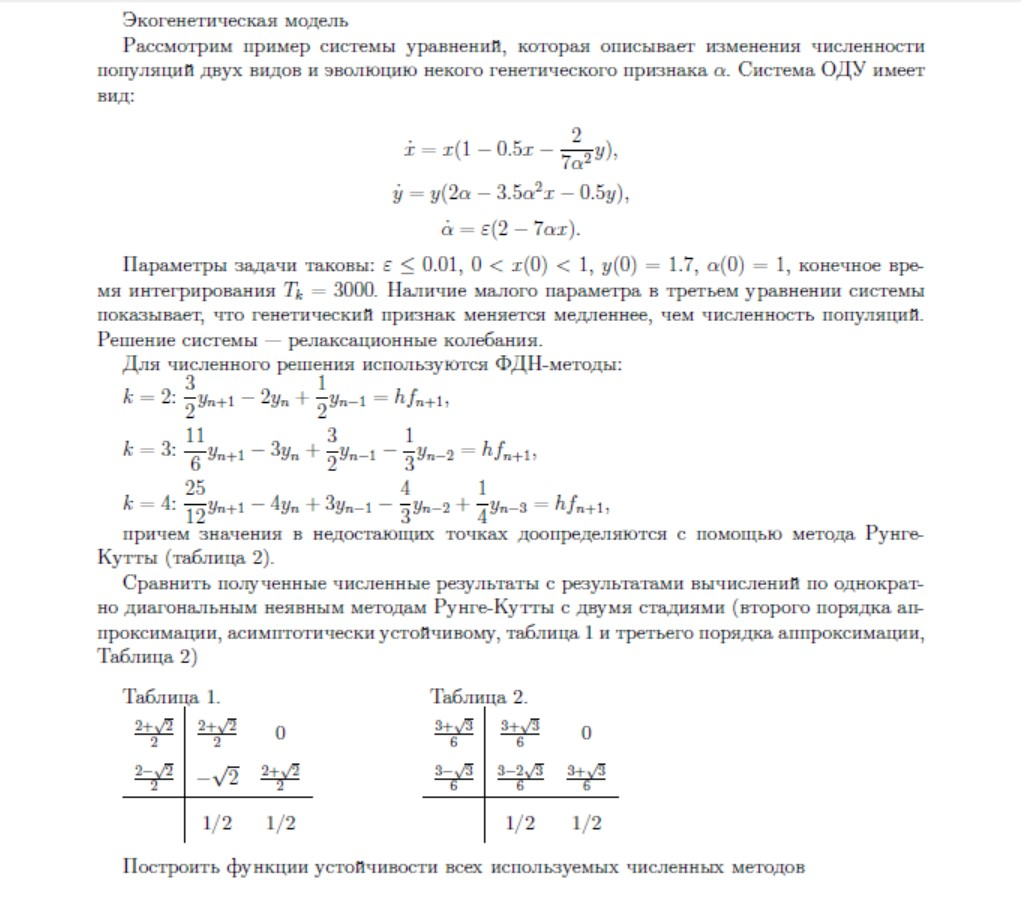

In [ ]:
Image(filename='13.4.jpg') 

In [3]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

### Правая часть системы
Заметим, что она не зависит явным образом от $t$, т.е. $f = f(u)$.

In [4]:
def f(u, epsilon=0.01):
    x, y, alpha = u
    return np.array([
        x*(1 - x/2 -(2/7/alpha**2)*y),
        y*(2*alpha - (7/2*alpha**2)*x - y/2),
        epsilon*(2 - 7*alpha*x)
    ])

## Реализация методов

### Однократно диагонально неявные методы Рунге-Кутты

В общем случае решается система уравнений вида
$$\dot{u} = f\left(t, u(t)\right), \quad f:\mathbb{R}\times\mathbb{R}^n\rightarrow\mathbb{R}^n$$

s-стадийным неявным методом Рунге-Кутты (РК) с определяющими коэффициентами $a_{ij}$, $b_i$, $c_i$ называется метод вида

$$u^{n+1}=u^{n}+\tau \sum_{i=1}^{s} b_{i} k_{i}$$
$$k_{i}=f\left(t_{n}+c_{i} \tau, u^{n}+\tau \sum_{j=1}^s a_{i j} k_{j}\right)$$

В данной задаче используются однократно диагонально неявные методы РК, т.е. такие, что для них выполнено $a_{i j}=0,\space j>i$ и $\forall i \mapsto a_{i i}=a$.

В этих условиях для вычисления $k_i$ требуется решить нелинейное уравнение следующего вида:

$$F(k_i) = f\left(t_{n}+c_{i} \tau, u^{n}+\tau \sum_{j=1}^{i-1} a_{i j} k_{j} + \tau a k_i\right) - k_{i} = 0$$

Так как система ДУ из условия задачи является автономной, нелинейное уравнение преобразуется к виду:

$$F(k_i) = f\left(u^{n}+\tau \sum_{j=1}^{i-1} a_{i j} k_{j} + \tau a k_i\right) - k_{i} = 0$$

Будем решать его с помощью функции `fsolve` пакета `scipy.optimize`.

In [5]:
class SDIRK_AutonomousSystem:
    """
    Однократно диагонально неявные методы Рунге-Кутты для автономных систем дифференциальных уравнений.

        Параметры:
        a_matrix - матрица размера sxs с a_ij = 0, i>j и a_ii=a для всех i
        b_vector, c_vector - векторы размера sx1
    """
    def __init__(self, a_matrix, b_vector):
        self.__A = a_matrix
        self.__b = b_vector
        self.__s = len(b_vector)
        
        
    def __nonlinear_equation(self, k_i, func, k, i, tau, u_n, params):
        return func(
            u_n 
            + tau*(self.__A[i - 1, :i] @ np.vstack((k[1:i], k_i))),
            **params
        ) - k_i
    
    
    def __call__(self, func, t_0, t_max, tau, u_0, **params):
        """
        Обсчет системы ДУ с правой частью func(u) на отрезке [t_0, t_max] с шагом tau (НУ u(t_0) = u_0).
        
        Параметры:
        func - функция правой части дифференциального уравнения f(t, u)
        t_0 - левая граница отрезка, на котором решается задача Коши
        t_max - правая граница отрезка, на котором решается задача Коши
        tau - величина шага на итерации
        u_0 - значение u(t_0)

        Возвращает значения u на сетке.
        """
        dim = len(u_0)  # размерность системы
        N = int((t_max - t_0) / tau) # число шагов
        u = np.zeros((N+1, dim))  # вектор u(t) в узлах сетки
        u[0] = u_0  # начальное приближение
        for n in range(N):
            k = np.zeros((self.__s + 1, dim))
            for i in range(1, self.__s + 1):
                k[i] = fsolve(self.__nonlinear_equation, k[i-1], args=(func, k, i, tau, u[n], params), maxfev=5000)
            u[n + 1] = u[n] + tau*(self.__b @ k[1:])
        return np.array([t_0 + n * tau for n in range(N+1)]), u  # сетка и решение

In [6]:
RKtable_2_order = [
    np.array([  # А
        [(2 + np.sqrt(2))/2, 0],
        [-np.sqrt(2), (2 + np.sqrt(2))/2]
    ]),
    np.array([1/2]*2),  # b
]

RKtable_3_order = [
    np.array([  # А
        [(3 + np.sqrt(3))/6, 0],
        [(3 - 2*np.sqrt(3))/6, (3 + np.sqrt(3))/6]
    ]),
    np.array([1/2]*2),  # b
]

In [7]:
RK_order2, RK_order3 = SDIRK_AutonomousSystem(*RKtable_2_order), SDIRK_AutonomousSystem(*RKtable_3_order)

### Проверка методов

In [121]:
import pandas as pd
from numpy.linalg import norm
from math import inf
from scipy.optimize import curve_fit

In [153]:
def test_system(u):
    x, y = u
    return np.array([x, -10*y])

In [154]:
def linear_func(x, k, b):
    return k * x + b

In [155]:
C_norm_x = pd.DataFrame(
    columns=['ЯМРК {} порядка точности'.format(j + 2) for j in range(2)],
    index = [2**(-i) for i in range(2, 10)]
)
C_norm_y = pd.DataFrame(
    columns=['ЯМРК {} порядка точности'.format(j + 2) for j in range(2)],
    index = [2**(-i) for i in range(2, 10)]
)

In [181]:
for tau in [2**(-i) for i in range(2, 10)]:
    for j, method in enumerate([RK_order2, RK_order3]):
        t, u = method(test_system, 0, 1, tau, [1, 1])
        C_norm_x['ЯМРК {} порядка точности'.format(j + 2)][tau] = np.log(norm(u[:, 0] - np.exp(t), inf))
        C_norm_y['ЯМРК {} порядка точности'.format(j + 2)][tau] = np.log(norm(u[:, 1] - np.exp(-10*t), inf))

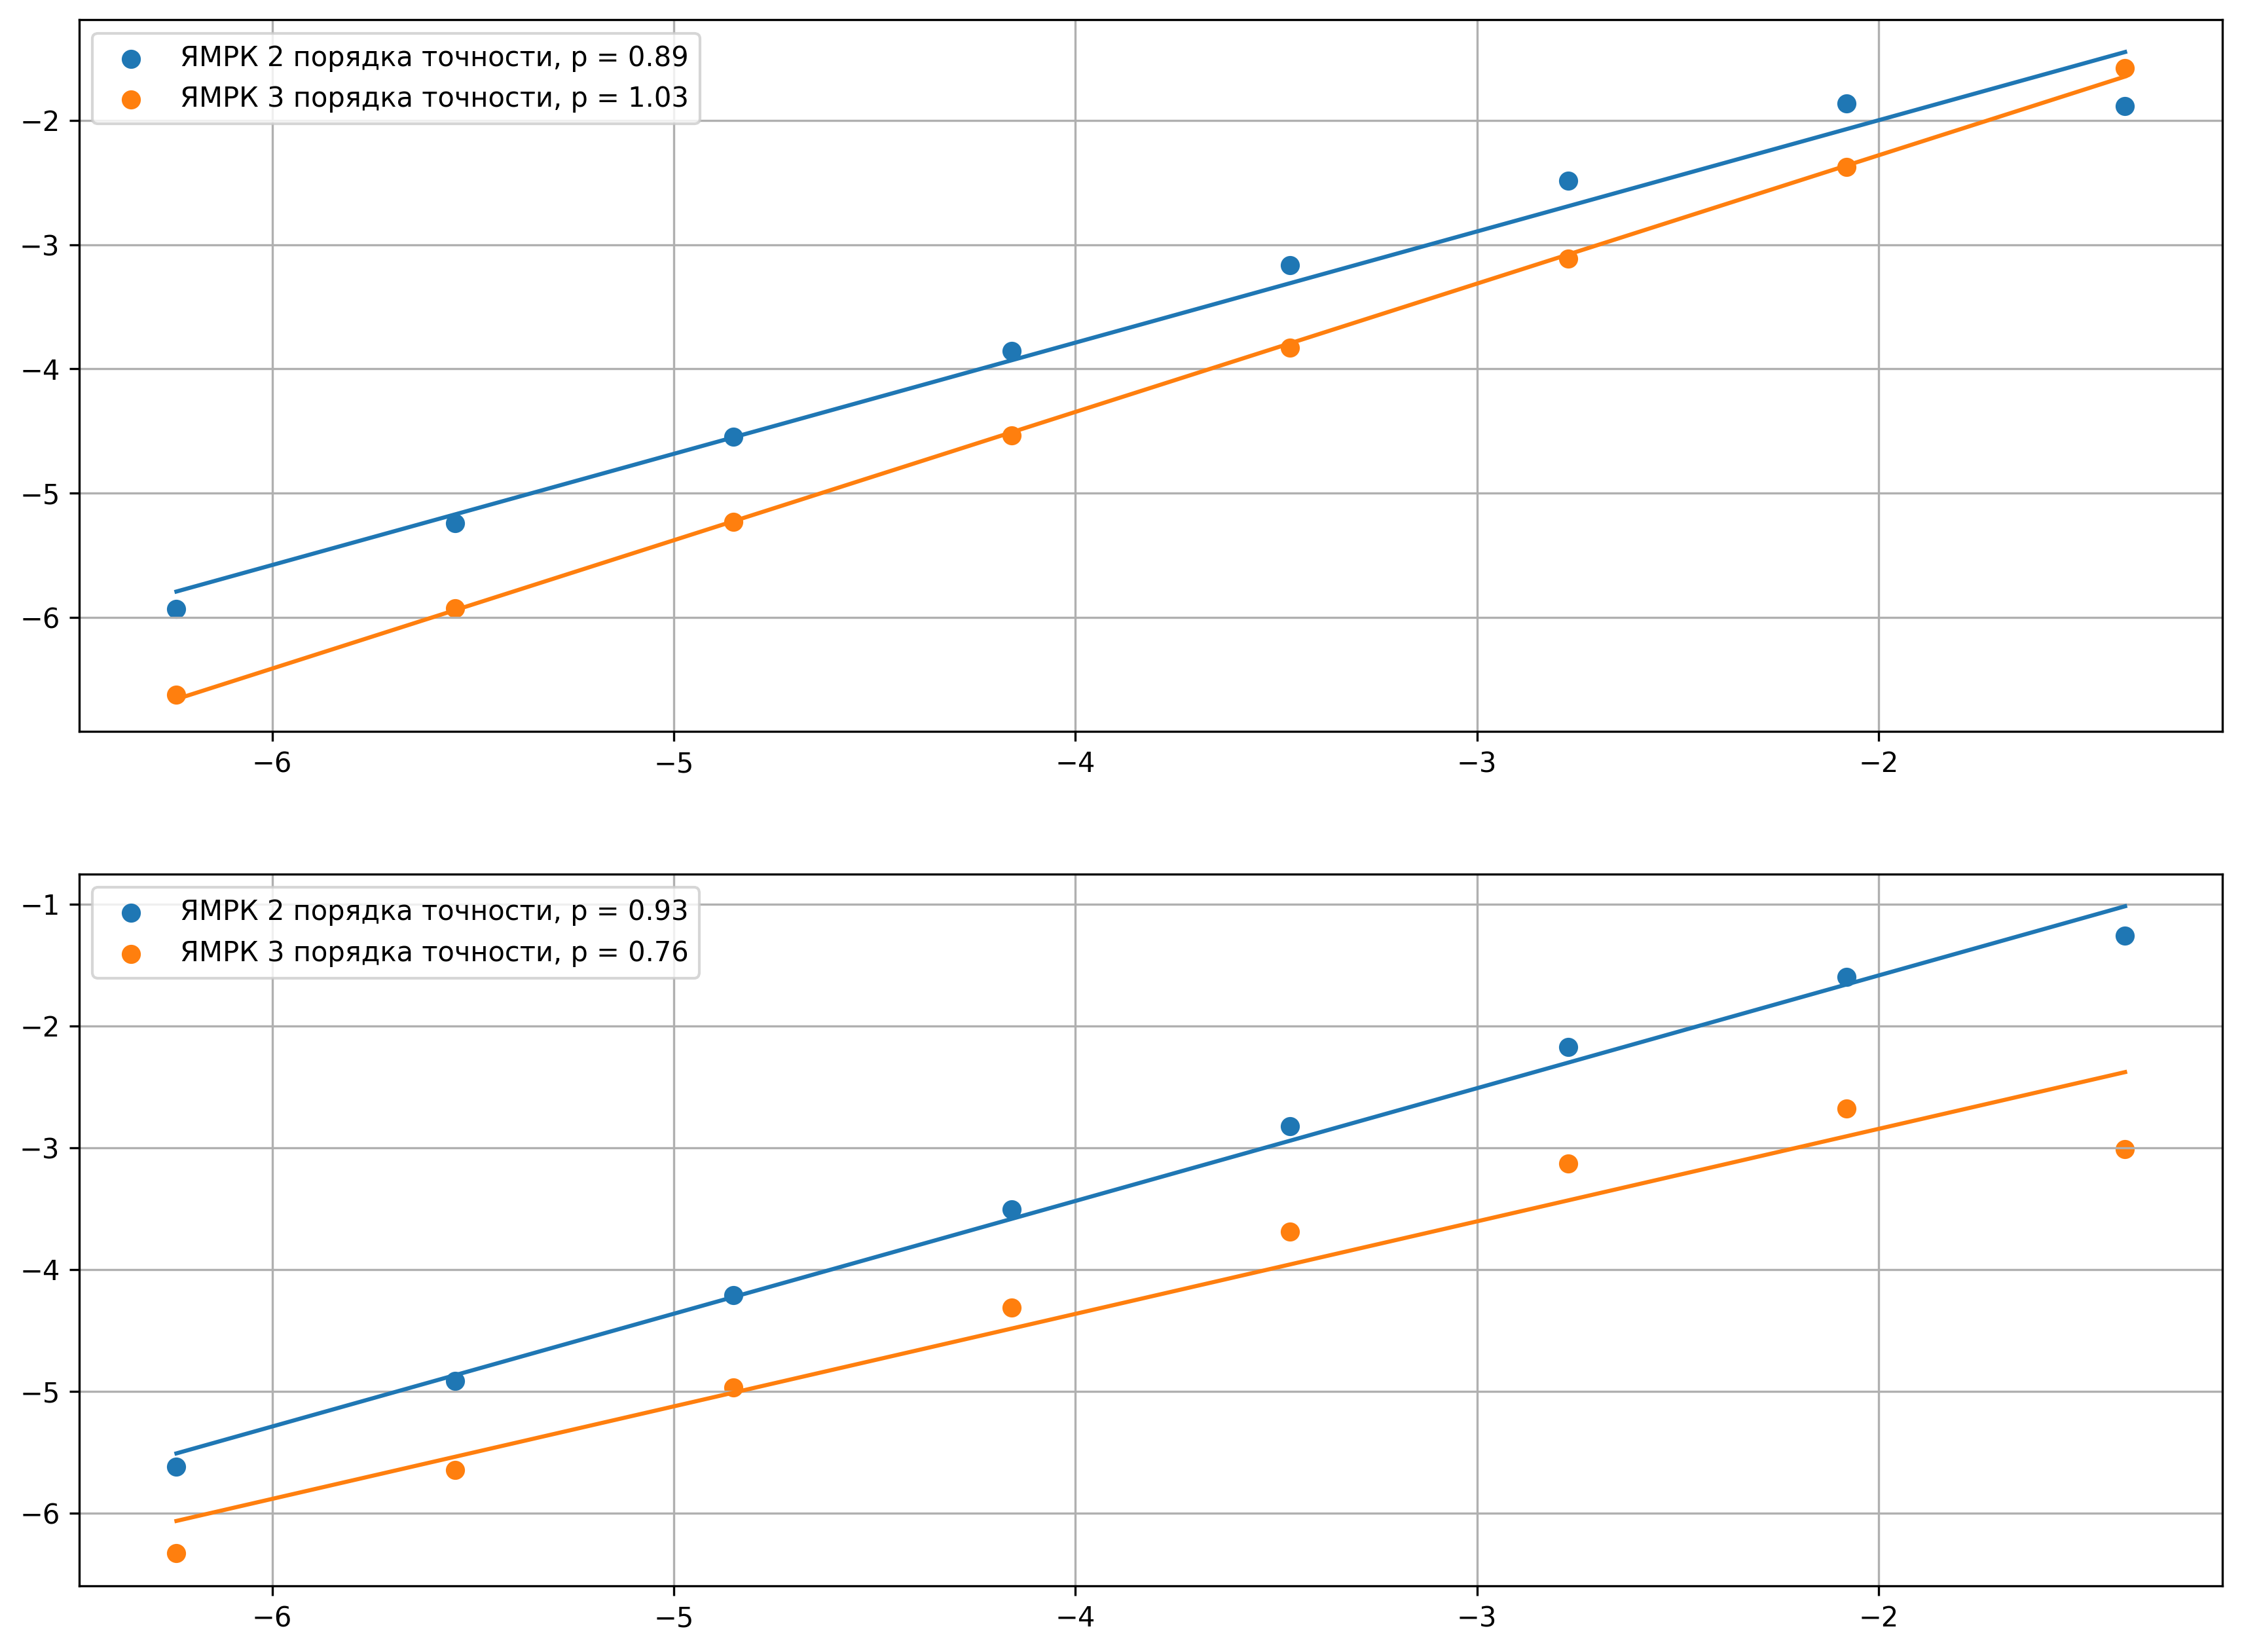

In [182]:
fig = plt.figure(figsize=(6.4 * 2.2, 4.8 * 2.2), dpi=300)
for i, C_norm in enumerate([C_norm_x, C_norm_y]):
    plt.subplot(2, 1, i+1)
    for column in C_norm.columns:
        params, _ = curve_fit(
            linear_func,
            np.log(C_norm.index),
            C_norm[column]
        )
        plt.scatter(np.log(C_norm.index), C_norm[column], label=column + ', p = {}'.format(round(params[0], 2)))
        plt.plot(np.log(C_norm.index), linear_func(np.log(C_norm.index), *params))
    plt.grid()
    plt.legend(loc='upper left')

### Функции устойчивости

Для методов РК функцию устойчивости $R(z), z = \tau \lambda$ можно найти следующим образом:

$$
\mathrm{R}(z)=\frac{\operatorname{det}\left(\mathbf{E}-z \mathbf{A}+z \mathbf{e b}^{T}\right)}{\operatorname{det}(\mathbf{E}-z \mathbf{A})}
$$

Область устойчивости метода задается выражением:

$$
|R(z)|\leq 1
$$

In [8]:
from numpy.linalg import det

In [9]:
def R(z: complex, A, b):
    s = len(b)
    return det(np.eye(s) - z*A + z*np.ones((s, 1)) @ b.reshape(1, 2)) / det(np.eye(s) - z*A)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


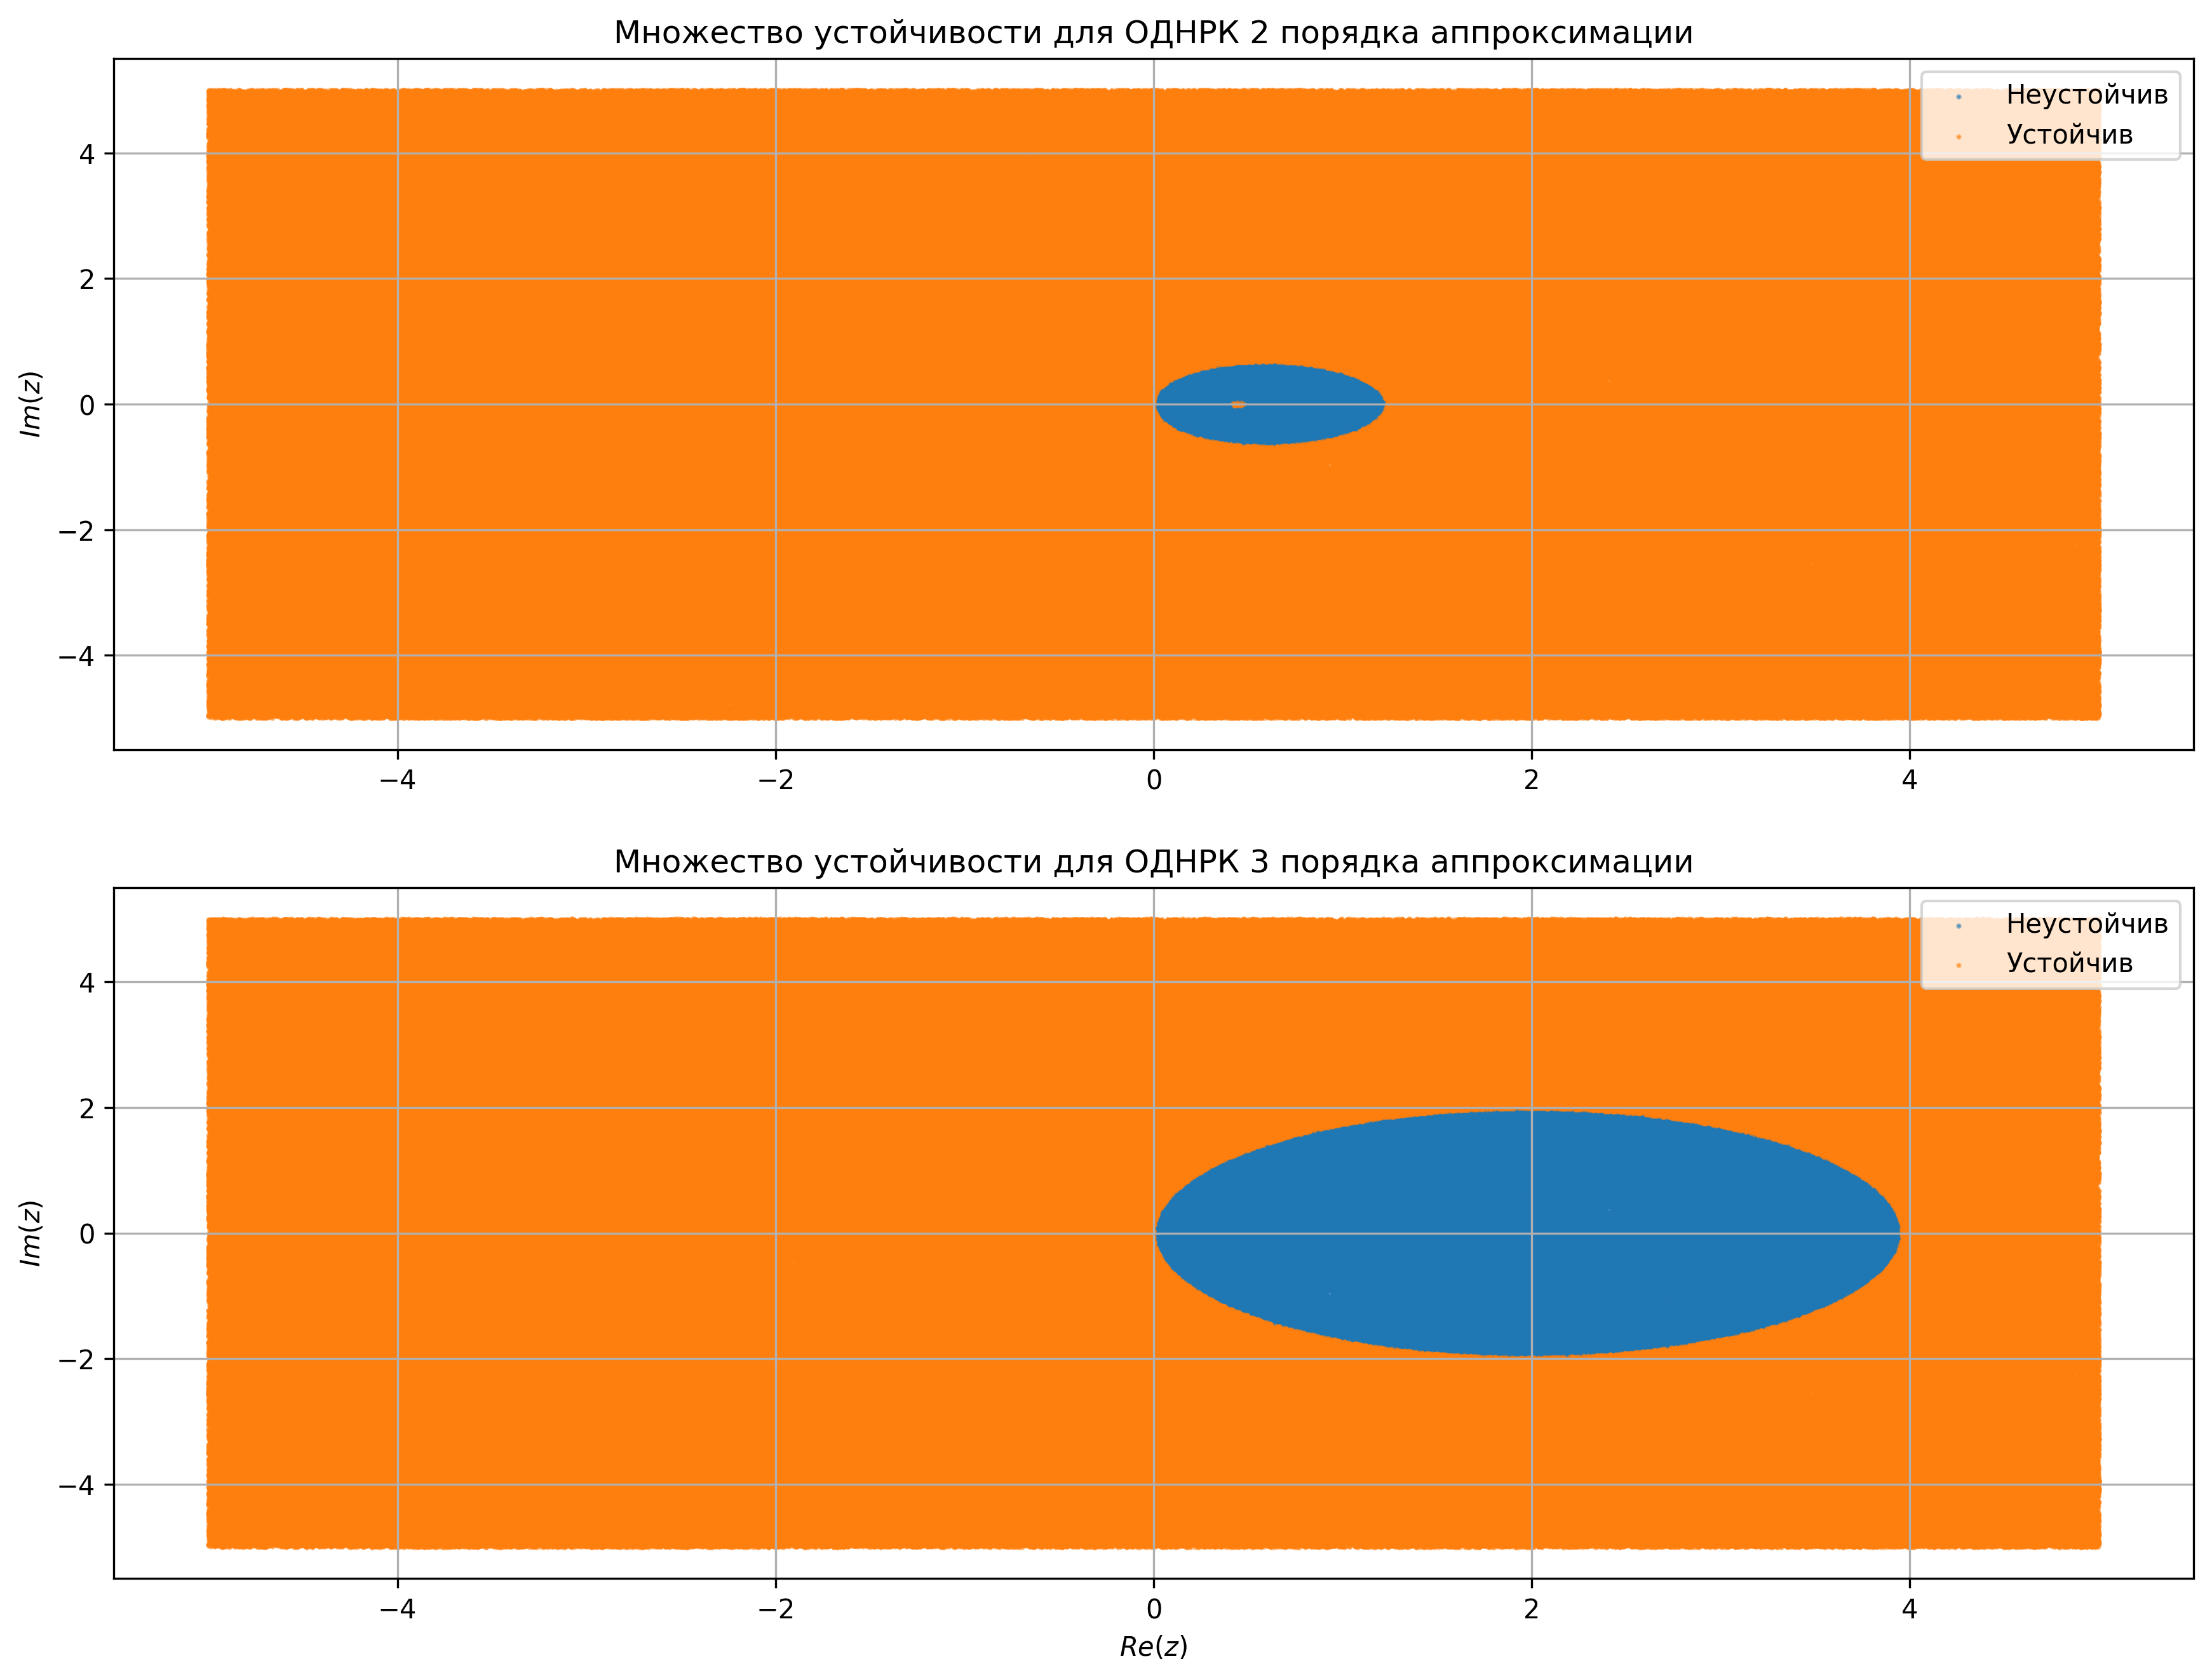

In [11]:
x_range, y_range = np.random.uniform(-5, 5, size=1000000), np.random.uniform(-5, 5, size=1000000)
z_range = x_range + 1j*y_range
stab_2_order = np.array([abs(R(z, *table_2_order)) <= 1 for z in z_range])
stab_3_order = np.array([abs(R(z, *table_3_order)) <= 1 for z in z_range])

fig = plt.figure(figsize=(6.4 * 2.2, 4.8 * 2.2), dpi=300)


def stab_func(value):
    return 'Устойчив' if value else 'Неустойчив'

for k, order in enumerate([stab_2_order, stab_3_order]):
    plt.subplot(2, 1, k+1)
    for g in np.unique(order):
        i = np.where(order == g)
        plt.scatter(x_range[i], y_range[i], s=1, label=stab_func(g), alpha=.5, cmap='Reds')
    plt.title(f'Множество устойчивости для ОДНРК {k+2} порядка аппроксимации')
    plt.ylabel('$Im(z)$')
    if k == 1:
        plt.xlabel('$Re(z)$')
    plt.legend(loc='upper right'); plt.grid()

### ФДН-методы

В задаче используются следующие методы ($k$ - порядок аппроксимации):
    
$$
\begin{array}{l}
k=2: \frac{3}{2} u_{n+1}-2 u_{n}+\frac{1}{2} u_{n-1}=\tau\space f_{n+1} \\
k=3: \frac{11}{6} u_{n+1}-3 u_{n}+\frac{3}{2} u_{n-1}-\frac{1}{3} u_{n-2}=\tau\space f_{n+1} \\
k=4: \frac{25}{12} u_{n+1}-4 u_{n}+3 u_{n-1}-\frac{4}{3} u_{n-2}+\frac{1}{4} u_{n-3}=\tau\space f_{n+1}
\end{array}
$$

или в более удобном для реализации виде (учитывая, что решаемая система - автономная):

$$
\left(\overrightarrow {K}, u_{n-k+1}^{n+1}\right)=\tau\space f_{n+1} = \tau\space f\left(u^{n+1}\right),
$$

где $\overrightarrow {K}$ - вектор коэффициентов ФДН-метода, а $u_{n-k+1}^{n+1} = \left(u^{n-k+1}, u^n, \dots, u^{n+1}\right)^T$, $k$ - порядок аппроксимации формулы.

Таким образом для нахождения значения $u^{n+1}$ требуется решить следующую нелинейную систему:

$$
F\left(u^{n+1}\right) = \left(\overrightarrow {K}, u_{n-k+1}^{n+1}\right) - \tau\space f\left(u^{n+1}\right) = 0,
$$

Видно, что для корректного решения задачи с помощью ФДН-метода порядка аппроксимации $k$ требуется дополнительно задать начальные значения функции в $k-1$ точках $u^1, \dots, u^{k-1}$. Значения в этих точках будут вычислены с помощью однократно диагонально неявного метода РК 3-го порядка аппроксимации (см. выше).

In [14]:
class BDF_AutonomousSystem:
    """
    ФДН-методы для автономных систем дифференциальных уравнений.

        Параметры:
        K - вектор коэффициентов метода размерности k+1 
        (начиная с точки с наименьшим индексом, k - порядок аппроксимации метода)
    """
    def __init__(self, K):
        self.__K = K
        self.__k = len(K) - 1

        
    def __nonlinear_equation(self, u_next, func, u, i, tau, params):
        return self.__K @ np.vstack((u[i-self.__k: i], u_next)) - tau*func(u_next, **params)
        
        
    def __call__(self, func, t_0, t_max, tau, u_0, **params):
        """
        Обсчет системы ДУ с правой частью func(u) на отрезке [t_0, t_max] с шагом tau (НУ u(t_0) = u_0).
        
        Параметры:
        func - функция правой части дифференциального уравнения f(t, u)
        t_0 - левая граница отрезка, на котором решается задача Коши
        t_max - правая граница отрезка, на котором решается задача Коши
        tau - величина шага на итерации
        u_0 - значение u(t_0)

        Возвращает значения u на сетке.
        """
        dim = len(u_0)  # размерность системы
        N = int((t_max - t_0) / tau) # число шагов
        u = np.zeros((N+1, dim))  # вектор u(t) в узлах сетки
        u[0] = u_0  # начальное приближение
        RK_order3 = SDIRK_AutonomousSystem(*[  # метод РК для нахождения значений в первых k-1 точках
                np.array([  # А
                    [(3 + sqrt(3))/6, 0],
                    [(3 - 2*sqrt(3))/6, (3 + sqrt(3))/6]
                ]),
                np.array([1/2]*2),  # b
                np.array([(3 + sqrt(3))/6, (3 - sqrt(3))/6])  # c
            ])
        for i in range(1, self.__k):
            u[i] = RK_order3(func, t_0 + (i-1)*tau, t_0 + i*tau, tau, u[i-1])[1][-1]
        for i in range(self.__k, N+1):
            u[i] = fsolve(self.__nonlinear_equation, u[i-1], args=(func, u, i, tau, params), maxfev=5000)
        return [t_0 + n * tau for n in range(N+1)], u  # сетка и решение

In [12]:
BDF_koefs_2order = np.array([1/2, -2, 3/2])
BDF_koefs_3order = np.array([-1/3, 3/2, -3, 11/6])
BDF_koefs_4order = np.array([1/4, -4/3, 3, -4, 25/12])

In [15]:
BDF_order2, BDF_order3, BDF_order4 = BDF_AutonomousSystem(BDF_koefs_2order), BDF_AutonomousSystem(BDF_koefs_3order), BDF_AutonomousSystem(BDF_koefs_4order)

### Проверка методов

In [ ]:
t2, u2 = BDF_order2(test_system, 0, 1, 0.005, [1, 1])
t3, u3 = BDF_order3(test_system, 0, 1, 0.005, [1, 1])
t4, u4 = BDF_order4(test_system, 0, 1, 0.005, [1, 1])

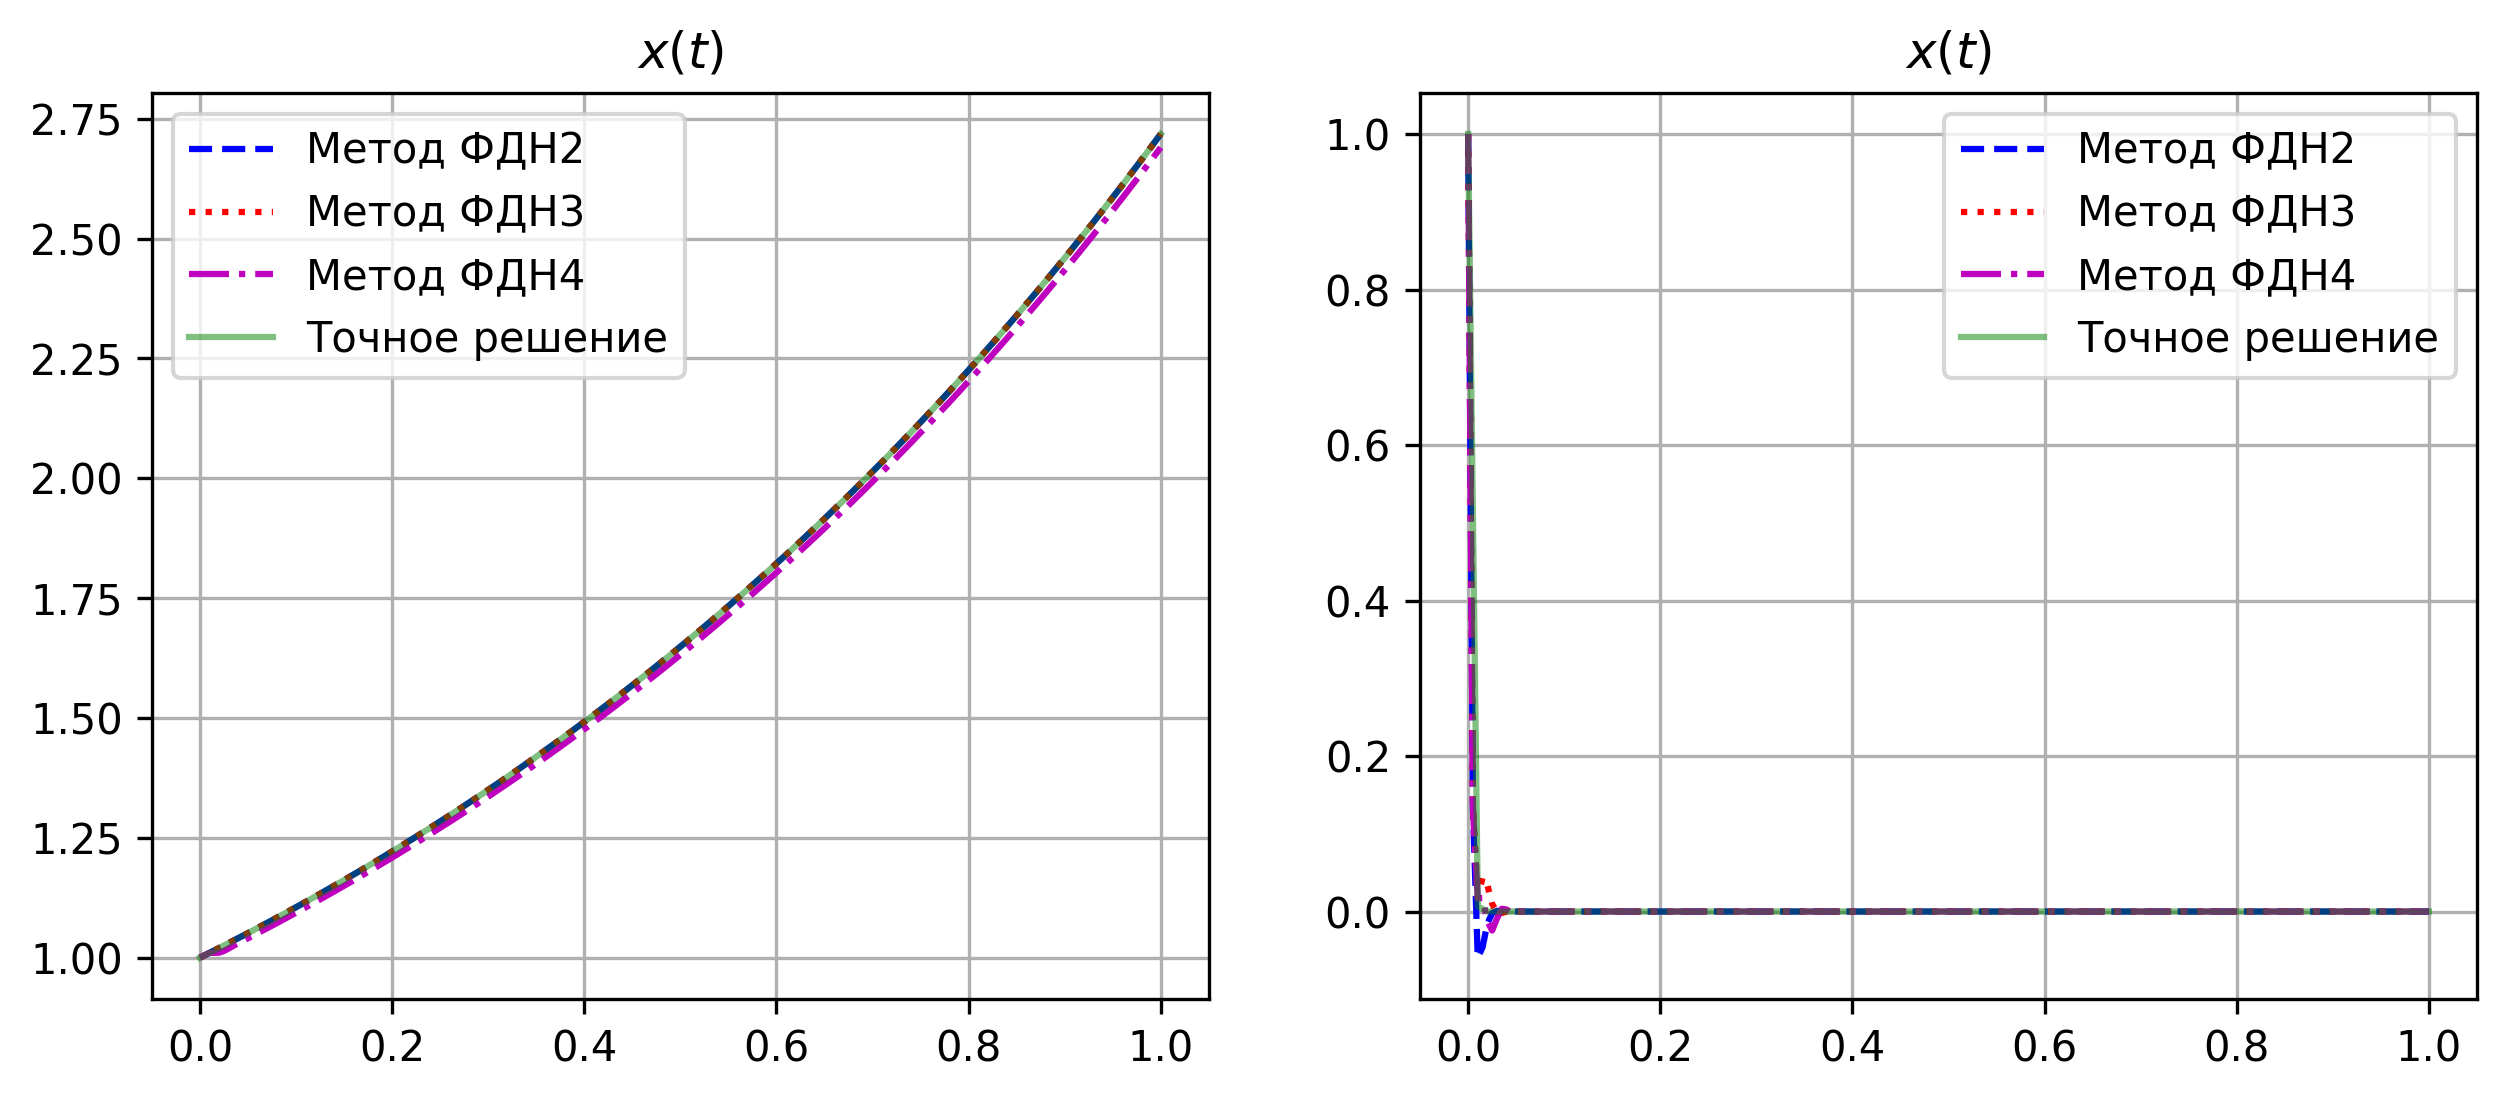

In [ ]:
plt.figure(figsize=(10,4), dpi=300)
tt = np.linspace(0, 1, 100)

plt.subplot(1, 2, 1)
plt.plot(t2, u2[:, 0], 'b--', label='Метод ФДН2')
plt.plot(t3, u3[:, 0], 'r:', label='Метод ФДН3')
plt.plot(t4, u4[:, 0], 'm-.', label='Метод ФДН4')
plt.plot(tt, np.exp(tt), 'g', label='Точное решение', alpha=.5)
plt.title('$x(t)$'); plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t2, u2[:, 1], 'b--', label='Метод ФДН2')
plt.plot(t3, u3[:, 1], 'r:', label='Метод ФДН3')
plt.plot(t4, u4[:, 1], 'm-.', label='Метод ФДН4')
plt.plot(tt, np.exp(-500*tt), 'g', label='Точное решение', alpha=.5)
plt.title('$x(t)$'); plt.legend(); plt.grid()

Видно, что с повышением порядка аппроксимации методы ФДН все больше теряют в устойчивости.

### Функции устойчивости

Для нахождения функции устойчивости ФДН-метода нужно непосредственно подставить модельное уравнение Далквиста $\dot{u} = \lambda u$ в метод, учтя, что 

$$
u_{n+m}=[R(z)]^{m} u_{n} .
$$

(формула для $R(z=\tau\lambda$) метода РК выводится так же)

Поскольку в этой задаче зависимость $R(z)$ не является однозначной, рассмотрим обратную ей, уже функцию, $z(R)$:

$$
\begin{array}{l}
k=2: \frac{3}{2} - \frac{2}{R}+\frac{1}{2R^2} =z \\
k=3: \frac{11}{6} - \frac{3}{R}+\frac{3}{2R^2}-\frac{1}{3R^3}=z \\
k=4: \frac{25}{12} - \frac{4}{R}+ \frac{3}{R^2}-\frac{4}{3R^3} +\frac{1}{4R^4} =z
\end{array}
$$

Для устойчивости нужно, чтобы было $|R(z)|\leq 1$. Рассмотрим, какие точки $z$ переходят в границу единичного круга $|R(z)| = 1$, т.е. $R = e^{i\theta}$.

Построим $z(\theta)$ для $\theta\in[0, 2\pi)$:

In [28]:
def z(R, koefs):
    return koefs @ np.array([R**(-i) for i in range(len(koefs))])

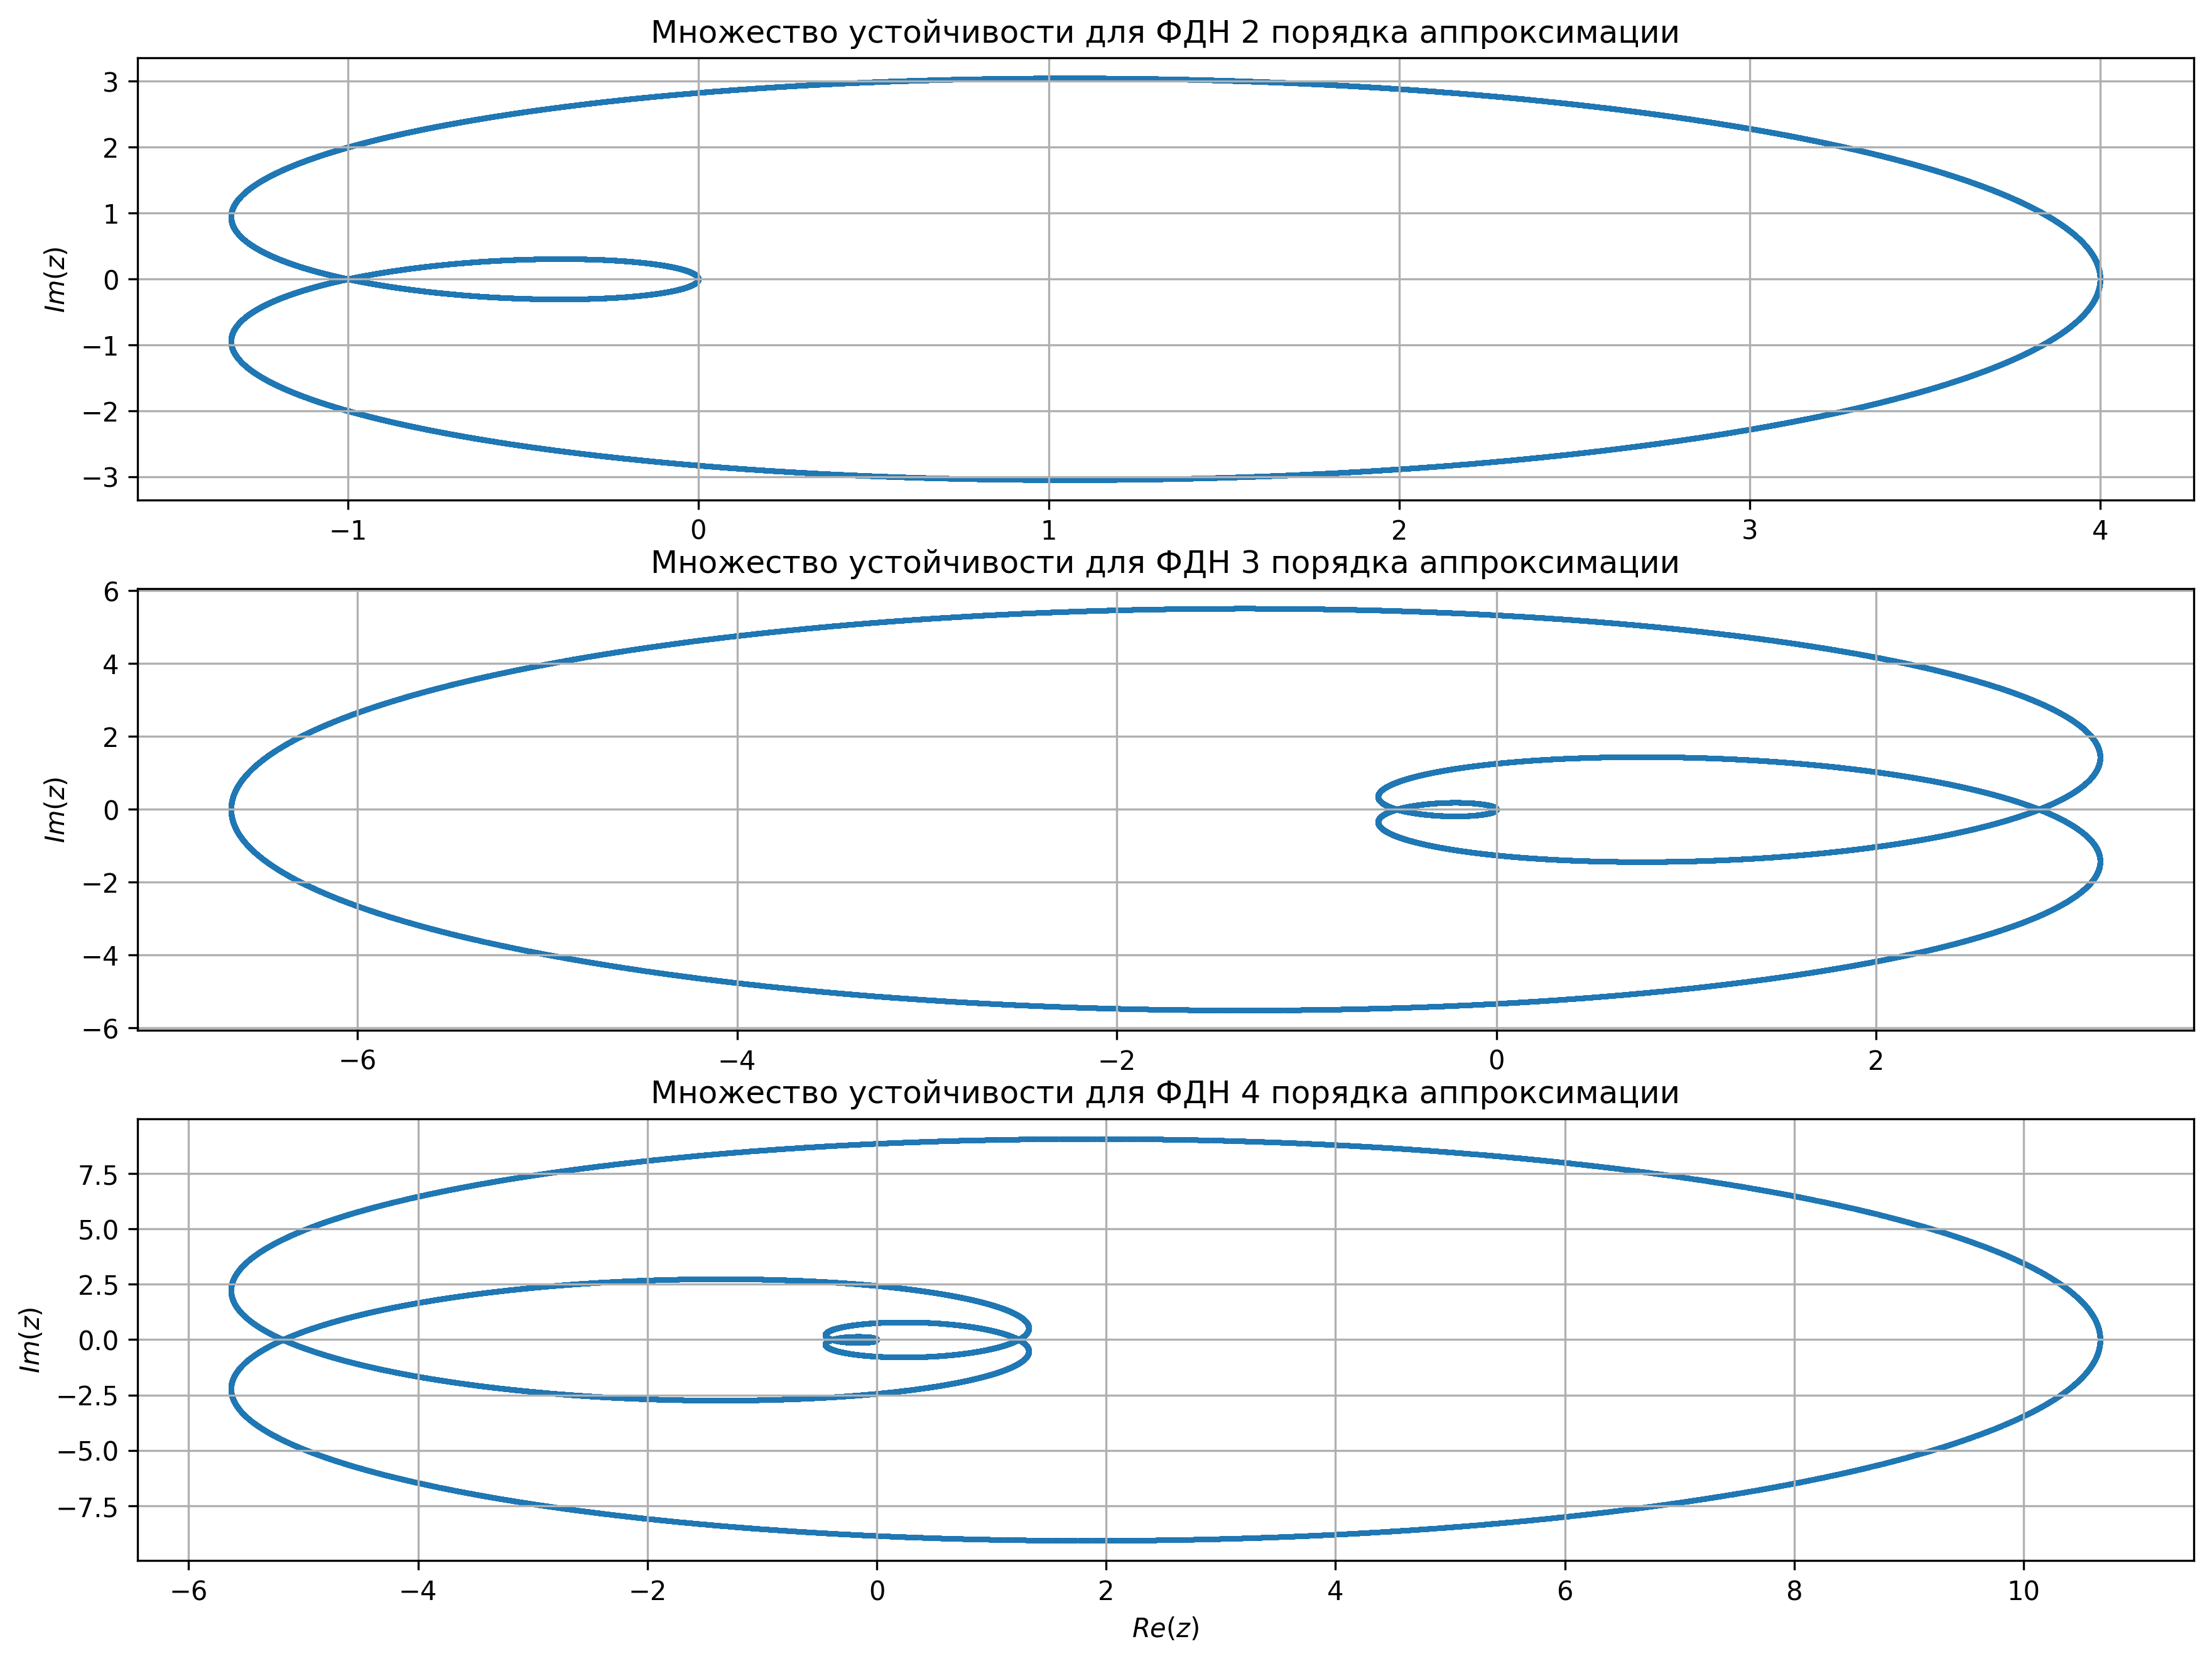

In [35]:
R = np.exp(1j*np.random.uniform(0, 2*np.pi, size=100000))

fig = plt.figure(figsize=(6.4 * 2.2, 4.8 * 2.2), dpi=300)
for k, koefs in enumerate([BDF_koefs_2order, BDF_koefs_3order, BDF_koefs_4order]):
    z_range = z(R, koefs)
    plt.subplot(3, 1, k+1)
    plt.scatter(z_range.real, z_range.imag, s=1, alpha=.5)
    plt.title(f'Множество устойчивости для ФДН {k+2} порядка аппроксимации')
    plt.ylabel('$Im(z)$')
    if k == 2:
        plt.xlabel('$Re(z)$')
    plt.grid()

Рассмотрим для начала множество устойчивости для ФДН 2 порядка. Внутри большой области, не включая петлю, метод является нестабильным. Снаружи этого множества и внутри петли метод устойчив.

Аналогично рекурсивным образом можно понять, какие области являются областями неустойчивости методов более высоких порядков (большое множество - неуст., петля внутри - уст., петля внутри петли - неуст., и т.д.).

Это можно понять и исходя из принципа сохранения области: если при обходе множества $|R(z)|=1$ область устойчивости оставалась слева, то и при обходе множества $z$ эта область будет слева.

## Решение задачи

### ФДН-методы

Промежуток времени, на котором решается задача - от $T_0=0$ до $T_k=3000$. Шаг $\tau$ будем брать из следующего множества: $\{ 0.5, 0.1, 0.05, 0.01, 0.001\}$. Начальные условия: $y(0)=1.7, \alpha (0) = 1$, $x(0)$ берется из множества $\{ 0.1, 0.3, \dots, 0.9\}$. Малый параметр $\varepsilon$ будем брать из множества $\{ 0.01, 0.005, 0.001, 0.0005, 0.0001 \}$.

In [ ]:
from itertools import product
from tqdm import tqdm

In [ ]:
def plot_phase_diagrams_and_solutions(x0_arr, epsilon_arr, tau_arr, method):
    x_dim, y_dim = len(x0_arr), len(epsilon_arr)
    fig1, axes1 = plt.subplots(x_dim, y_dim)
    fig2, axes2 = plt.subplots(x_dim, y_dim)
    fig3, axes3 = plt.subplots(x_dim, y_dim)
    for fig in [fig1, fig2, fig3]:
        fig.set_size_inches(6.4 * 2.2, 4.8 * 2.2)
        fig.set_dpi(300)
        fig.tight_layout(pad=2)
    fig1.suptitle(r'Фазовые траектории в зависимости от $x_0$, $\varepsilon$ и $\tau$', y=1.05)
    fig2.suptitle(r'Решение $x(t)$ в зависимости от $x_0$, $\varepsilon$ и $\tau$', y=1.05)
    fig3.suptitle(r'Решение $y(t)$ в зависимости от $x_0$, $\varepsilon$ и $\tau$', y=1.05)
    for i, (x0, epsilon) in tqdm(enumerate(product(
        x0_arr, 
        epsilon_arr
    ))):
        for tau in tau_arr:
            t, u = method(f, 0, 3000, tau, np.array([x0, 1.7, 1]), epsilon=epsilon)
            axes1[i // y_dim, i % y_dim].scatter(u[:, 0], u[:, 1], s=3, alpha=.5, label=r'$\tau$ = {}'.format(tau))
            axes2[i // y_dim, i % y_dim].scatter(t, u[:, 0], s=3, alpha=.5, label=r'$\tau$ = {}'.format(tau))
            axes3[i // y_dim, i % y_dim].scatter(t, u[:, 1], s=3, alpha=.5, label=r'$\tau$ = {}'.format(tau))
        for axes in [axes1, axes2, axes3]:
            axes[i // y_dim, i % y_dim].legend(loc='upper right', prop={'size': 7})
            axes[i // y_dim, i % y_dim].set_title(r'$x_0$ = {}, $\varepsilon$ = {}'.format(round(x0, 1), epsilon))
            axes[i // y_dim, i % y_dim].grid()
            axes[i // y_dim, i % y_dim].ticklabel_format(useOffset=False)
    for axes in [axes1, axes2, axes3]:
        for i, ax in enumerate(axes):
            if i == len(axes) - 1:
                ax[0].set(xlabel=r'$x(t)$', ylabel=r'$y(t)$')
                ax[1].set(xlabel=r'$x(t)$')
            else:
                ax[0].set(ylabel=r'$y(t)$')




0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 5000.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



1it [01:29, 89.26s/it]/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)



2it [02:37, 83.03s/it]


3it [04:08, 85.48s/it]


4it [05:19, 80.97s/it]


5it [06:35, 79.56s/it]


6it [07:46, 76.81s/it]


7it [08:50, 73.20s/it]


8it [10:00, 72.25s/it]


9it [11:12, 71.93s/it]


10it [12:29, 73.52s/it]


11it [13:40, 72.77s/it]


12it [14:46, 70.70s/it]


13it [15:58, 71.10s/

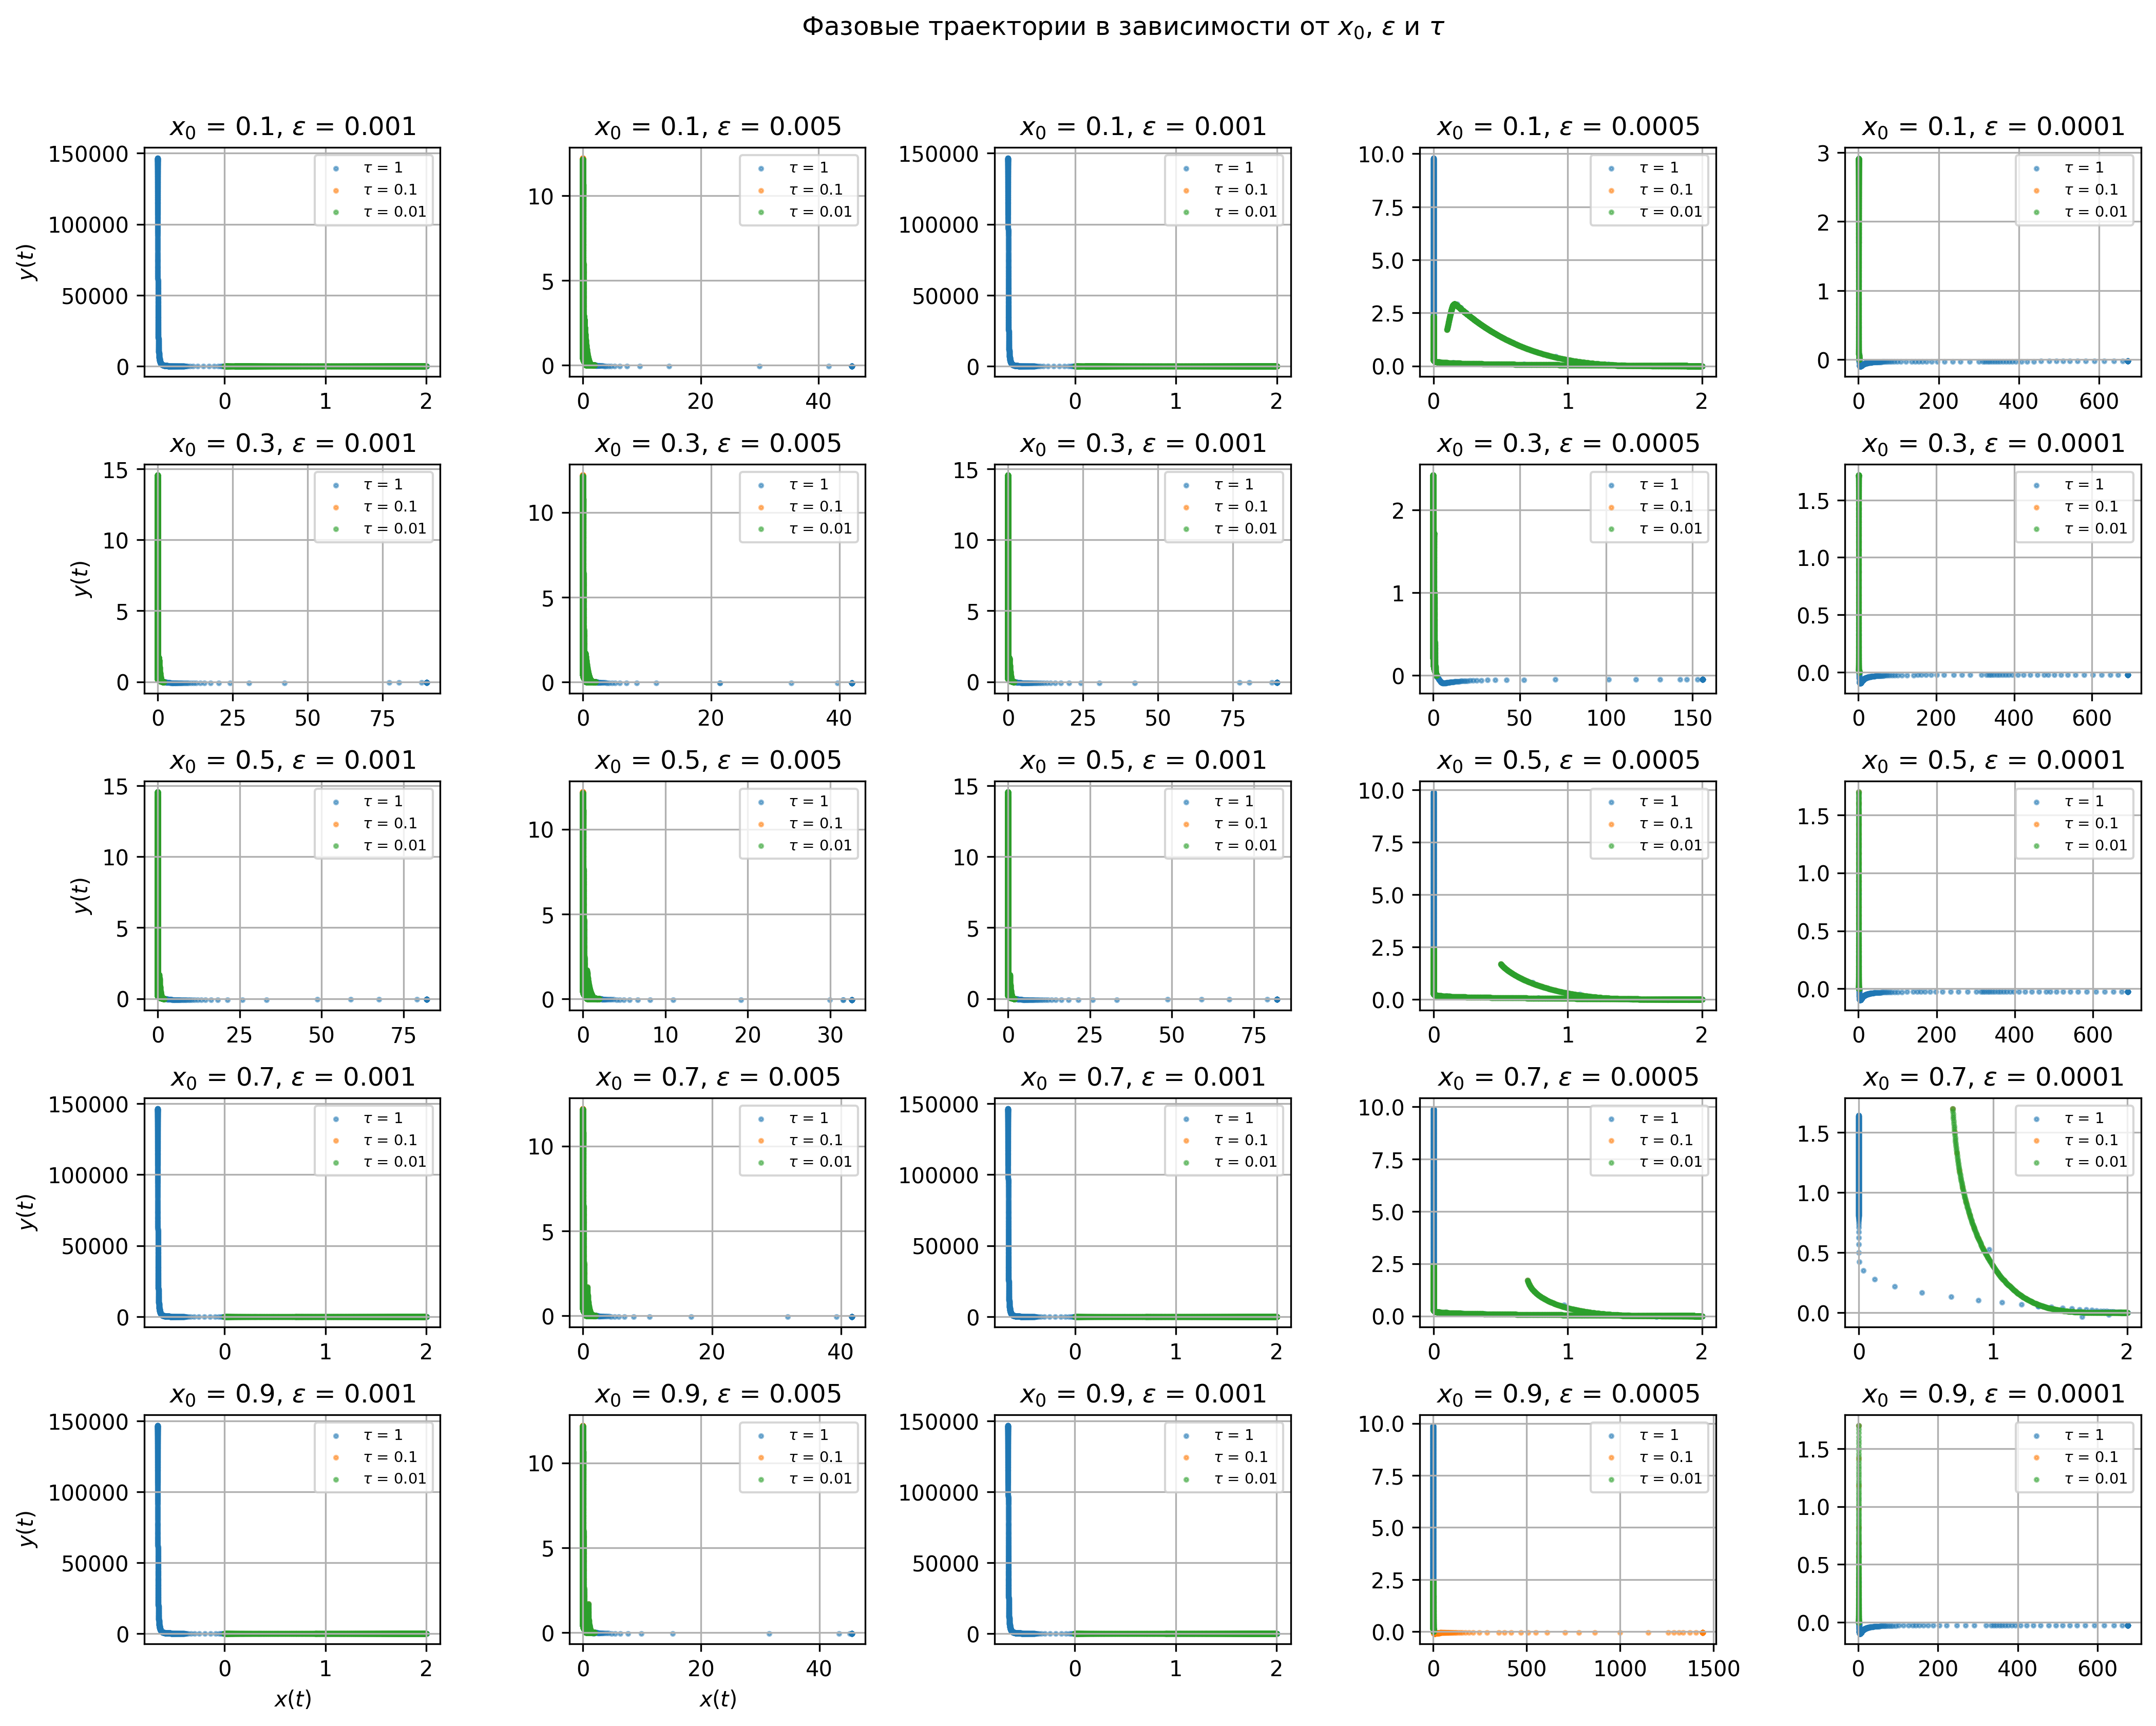

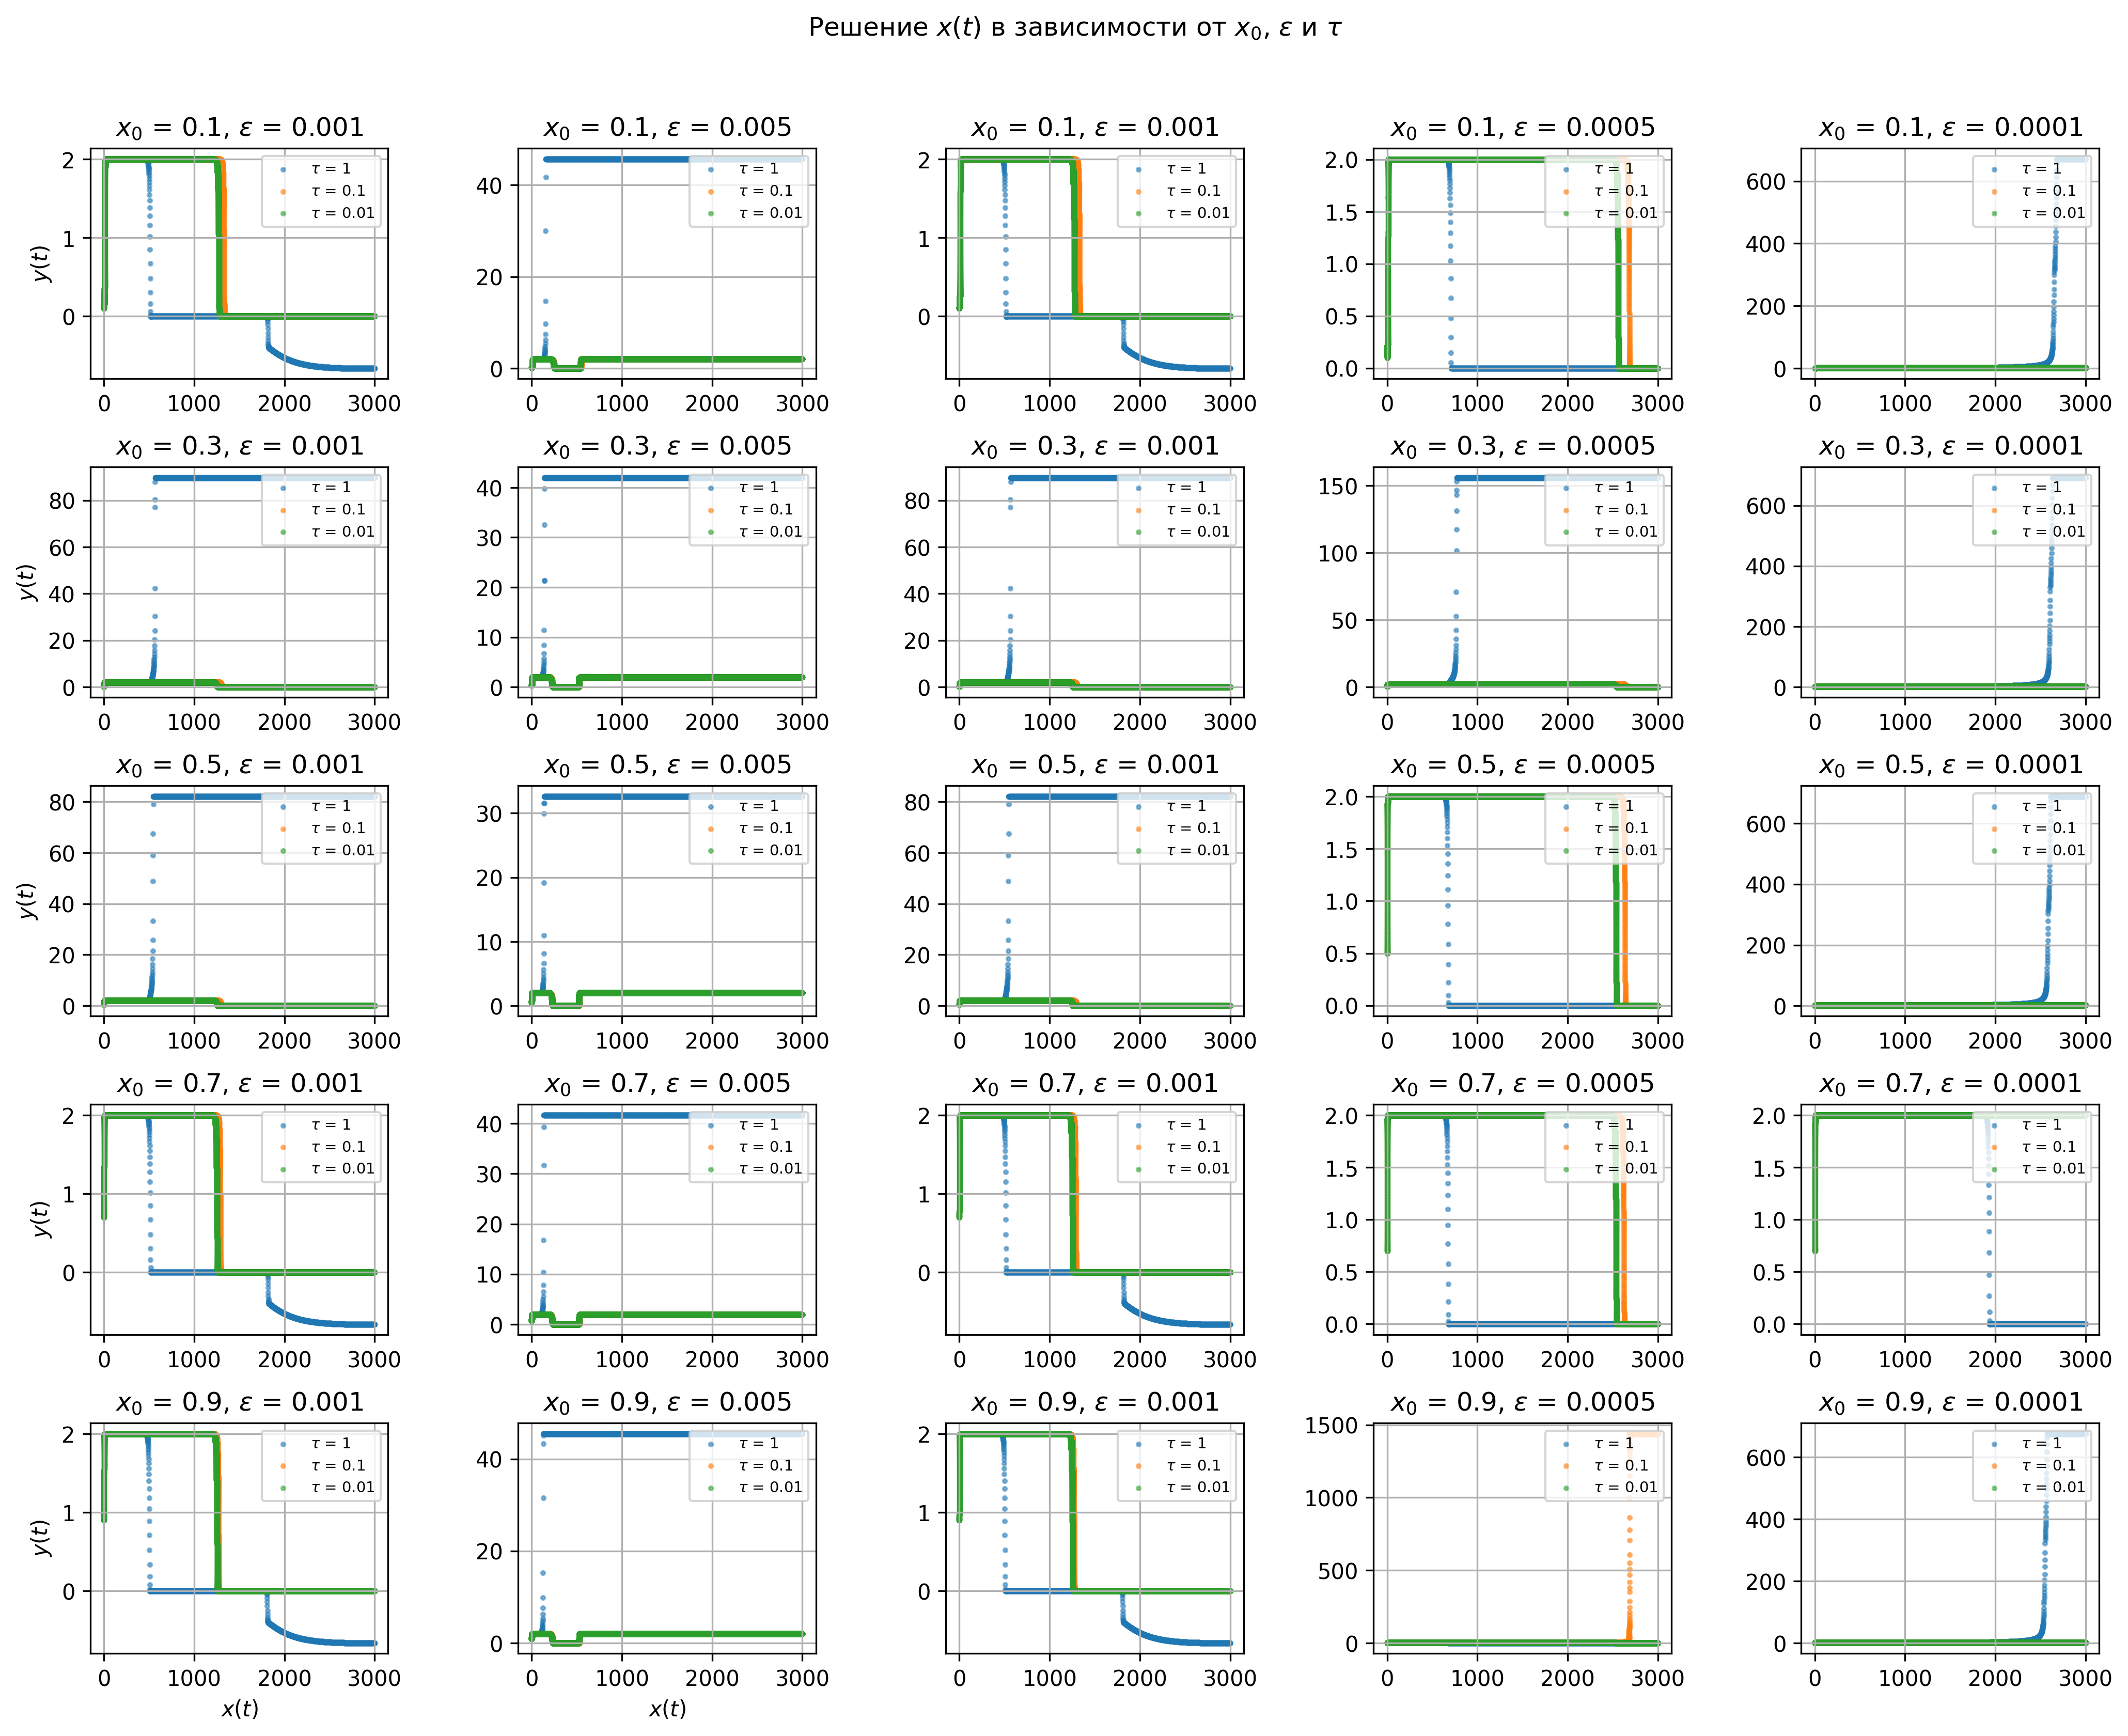

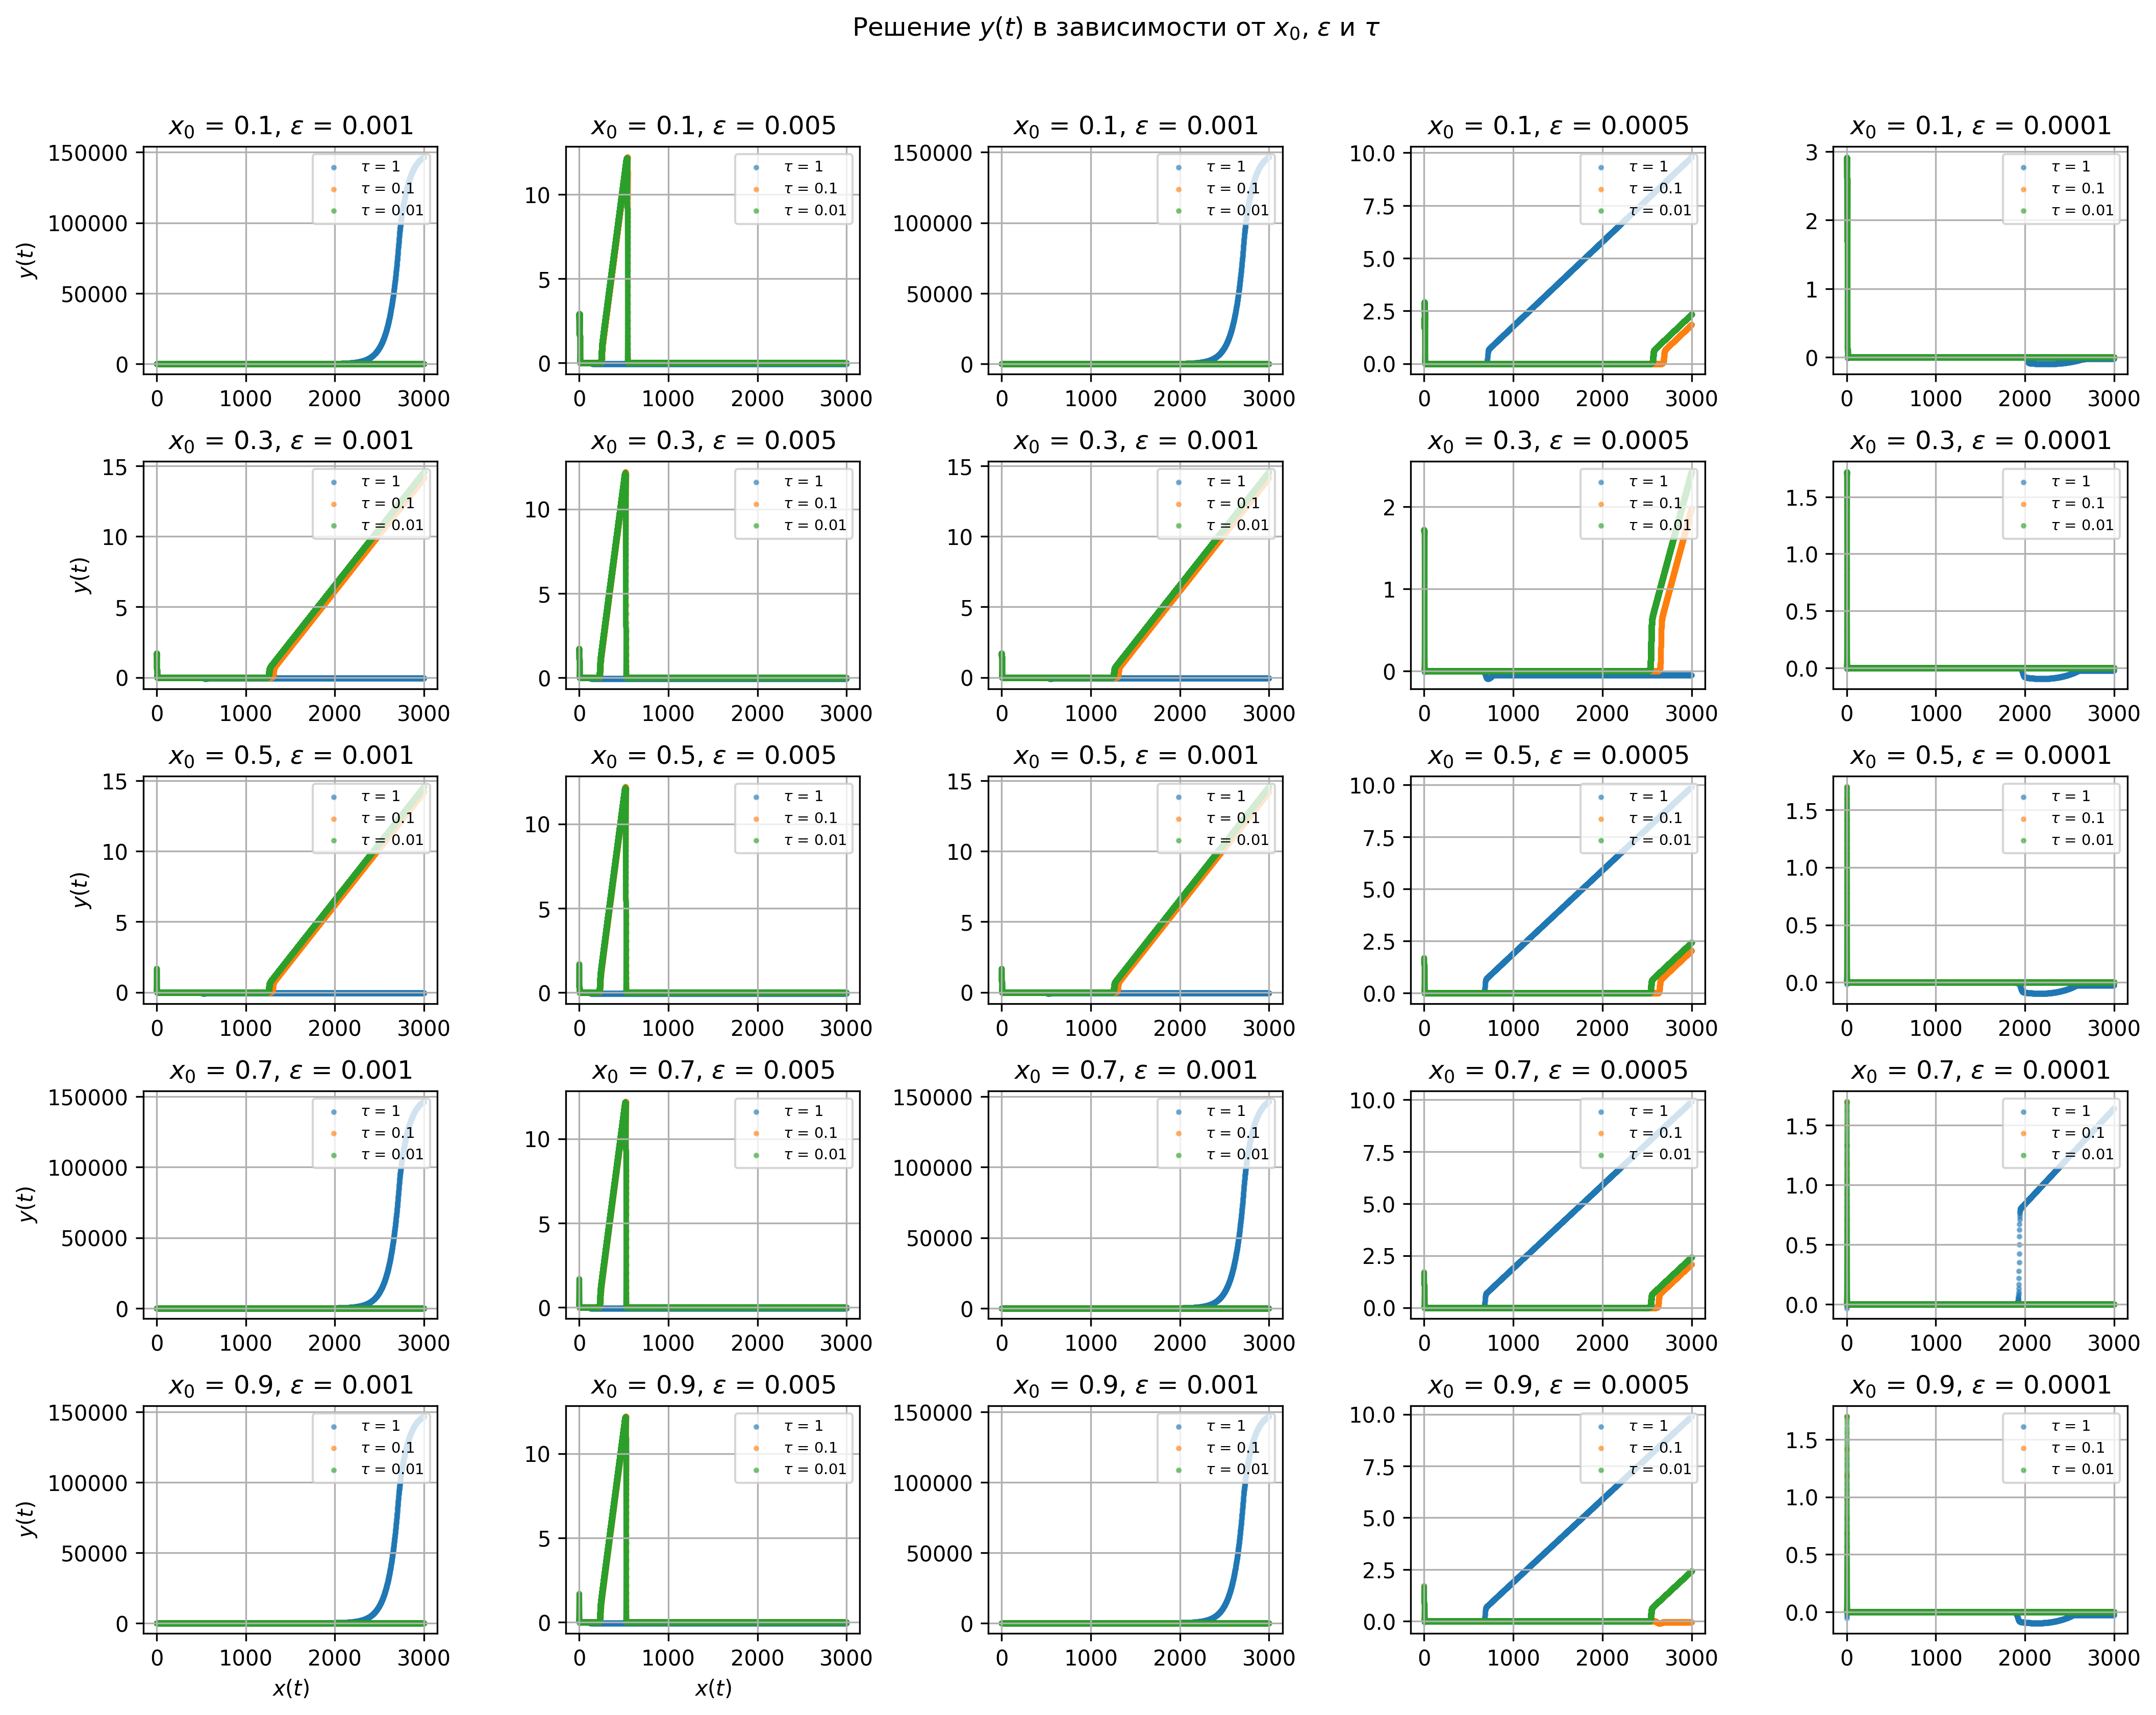

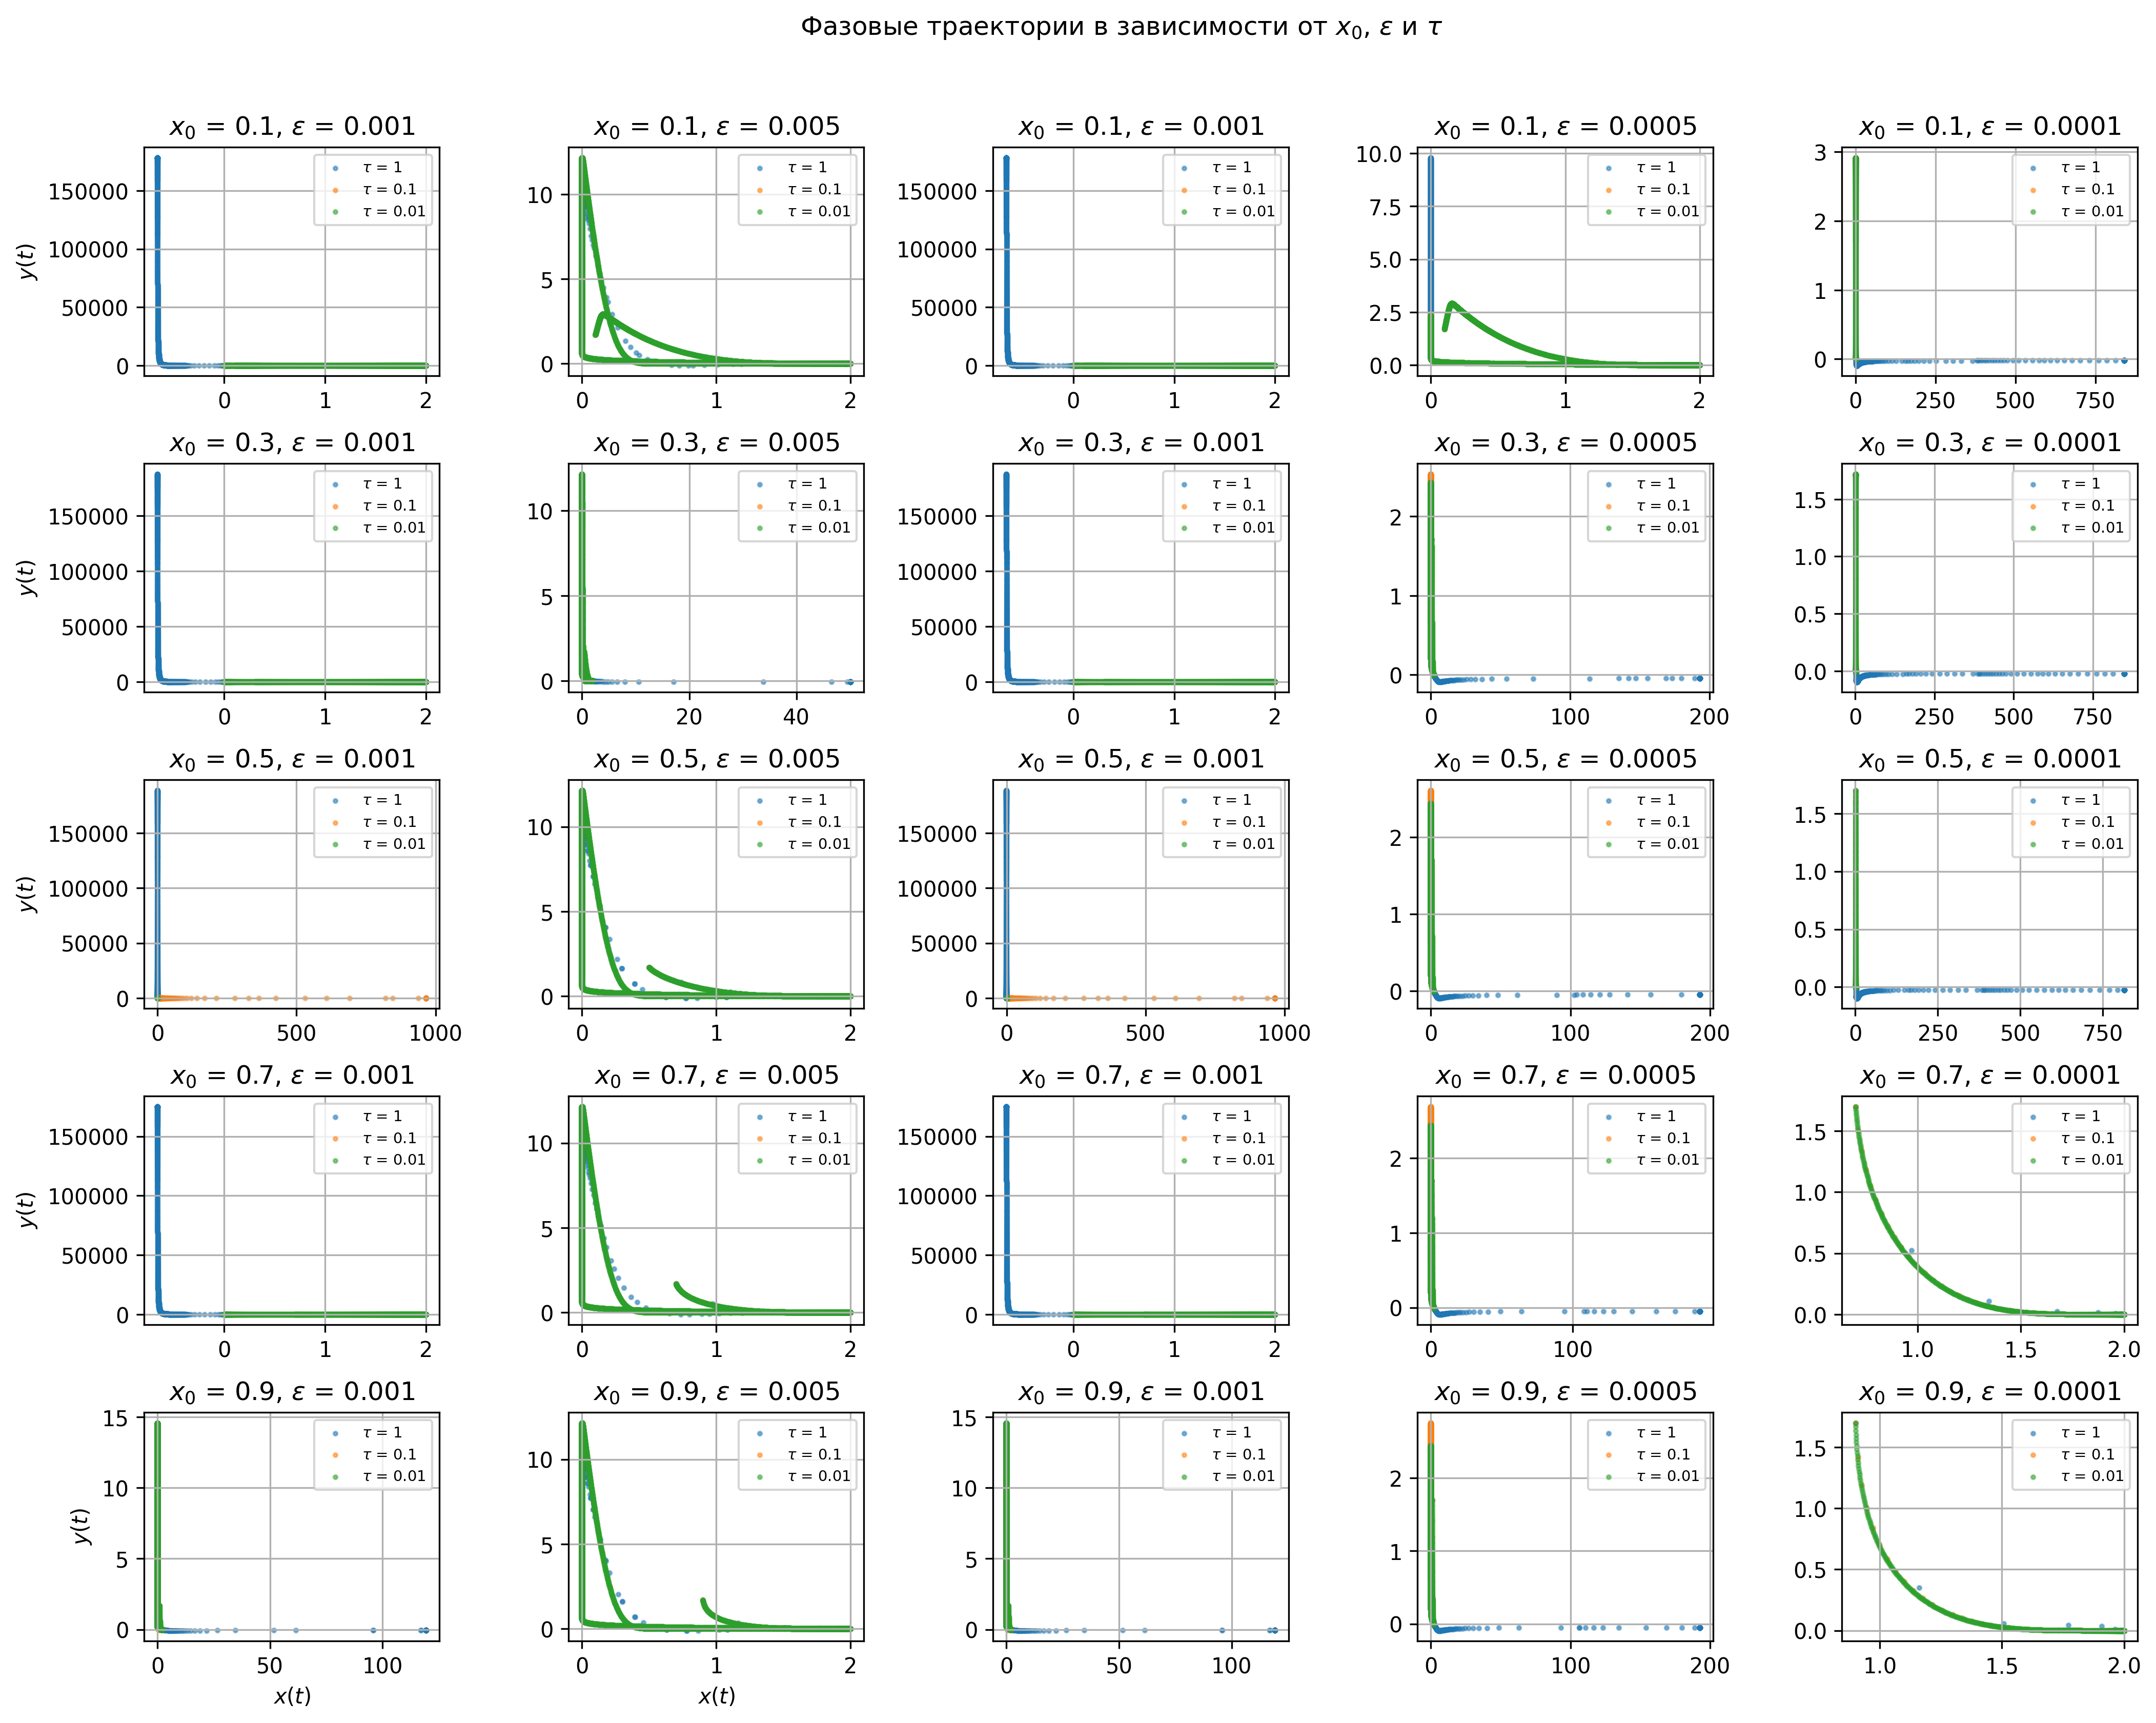

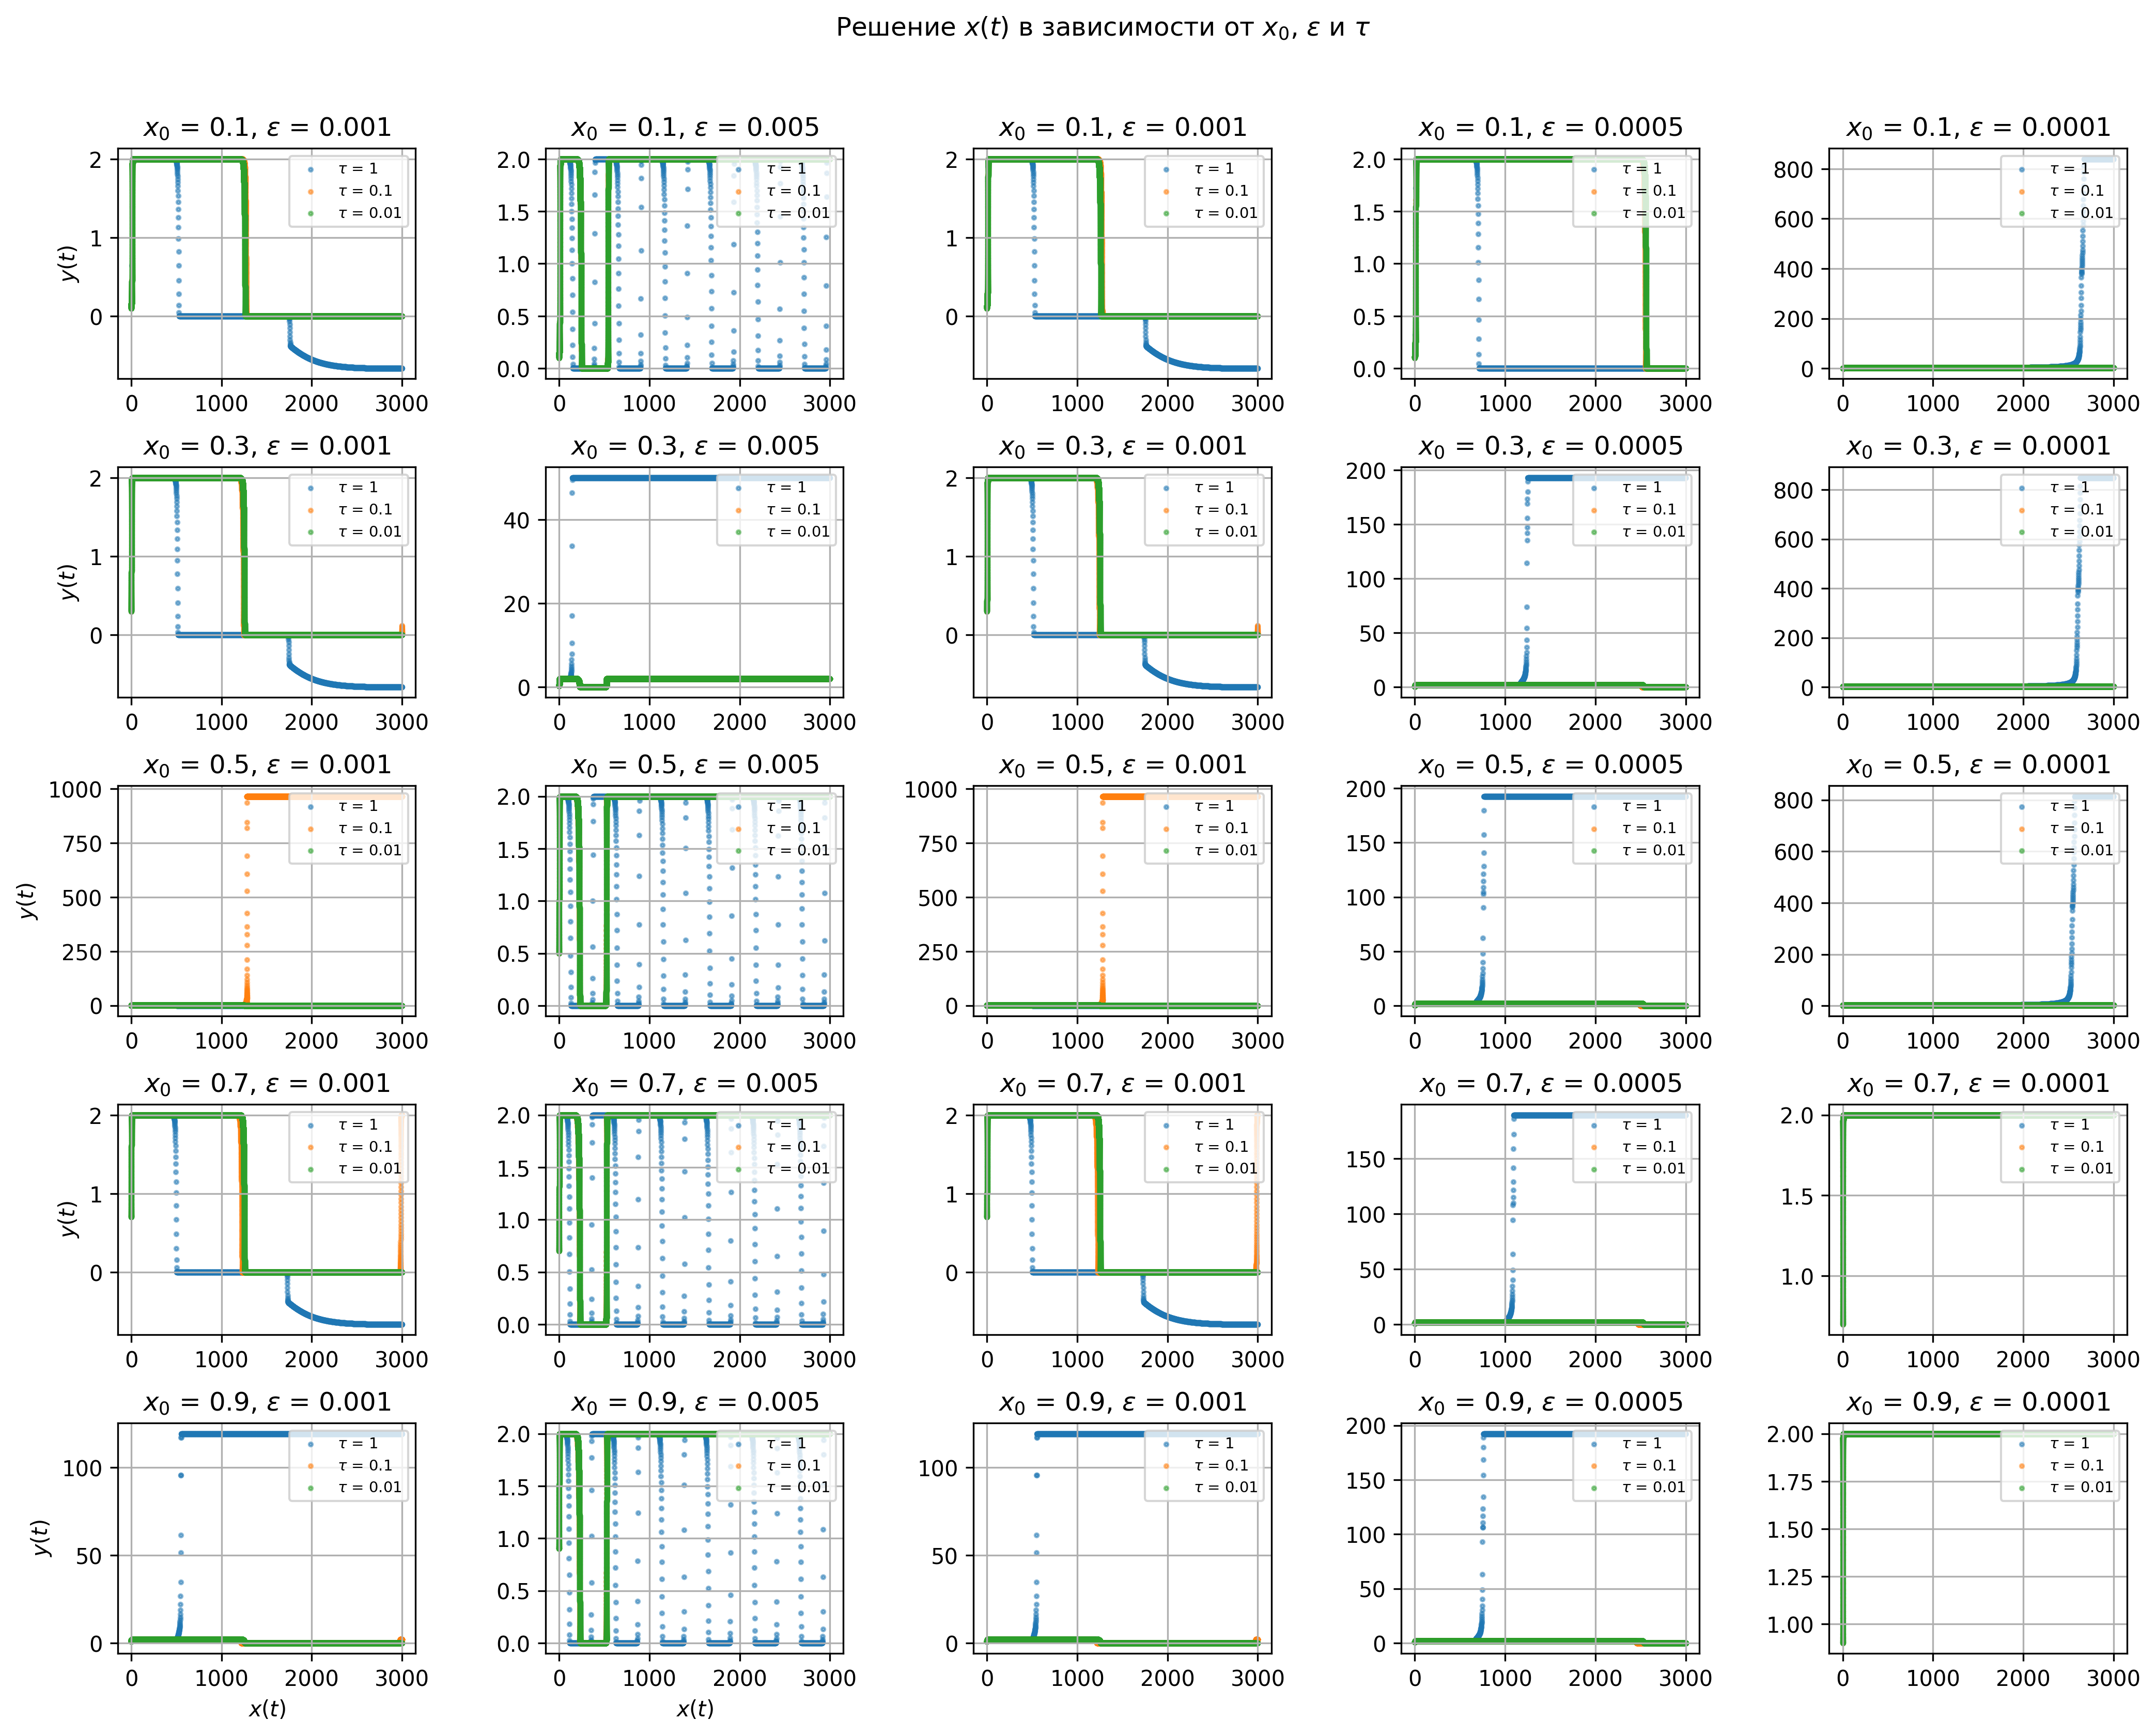

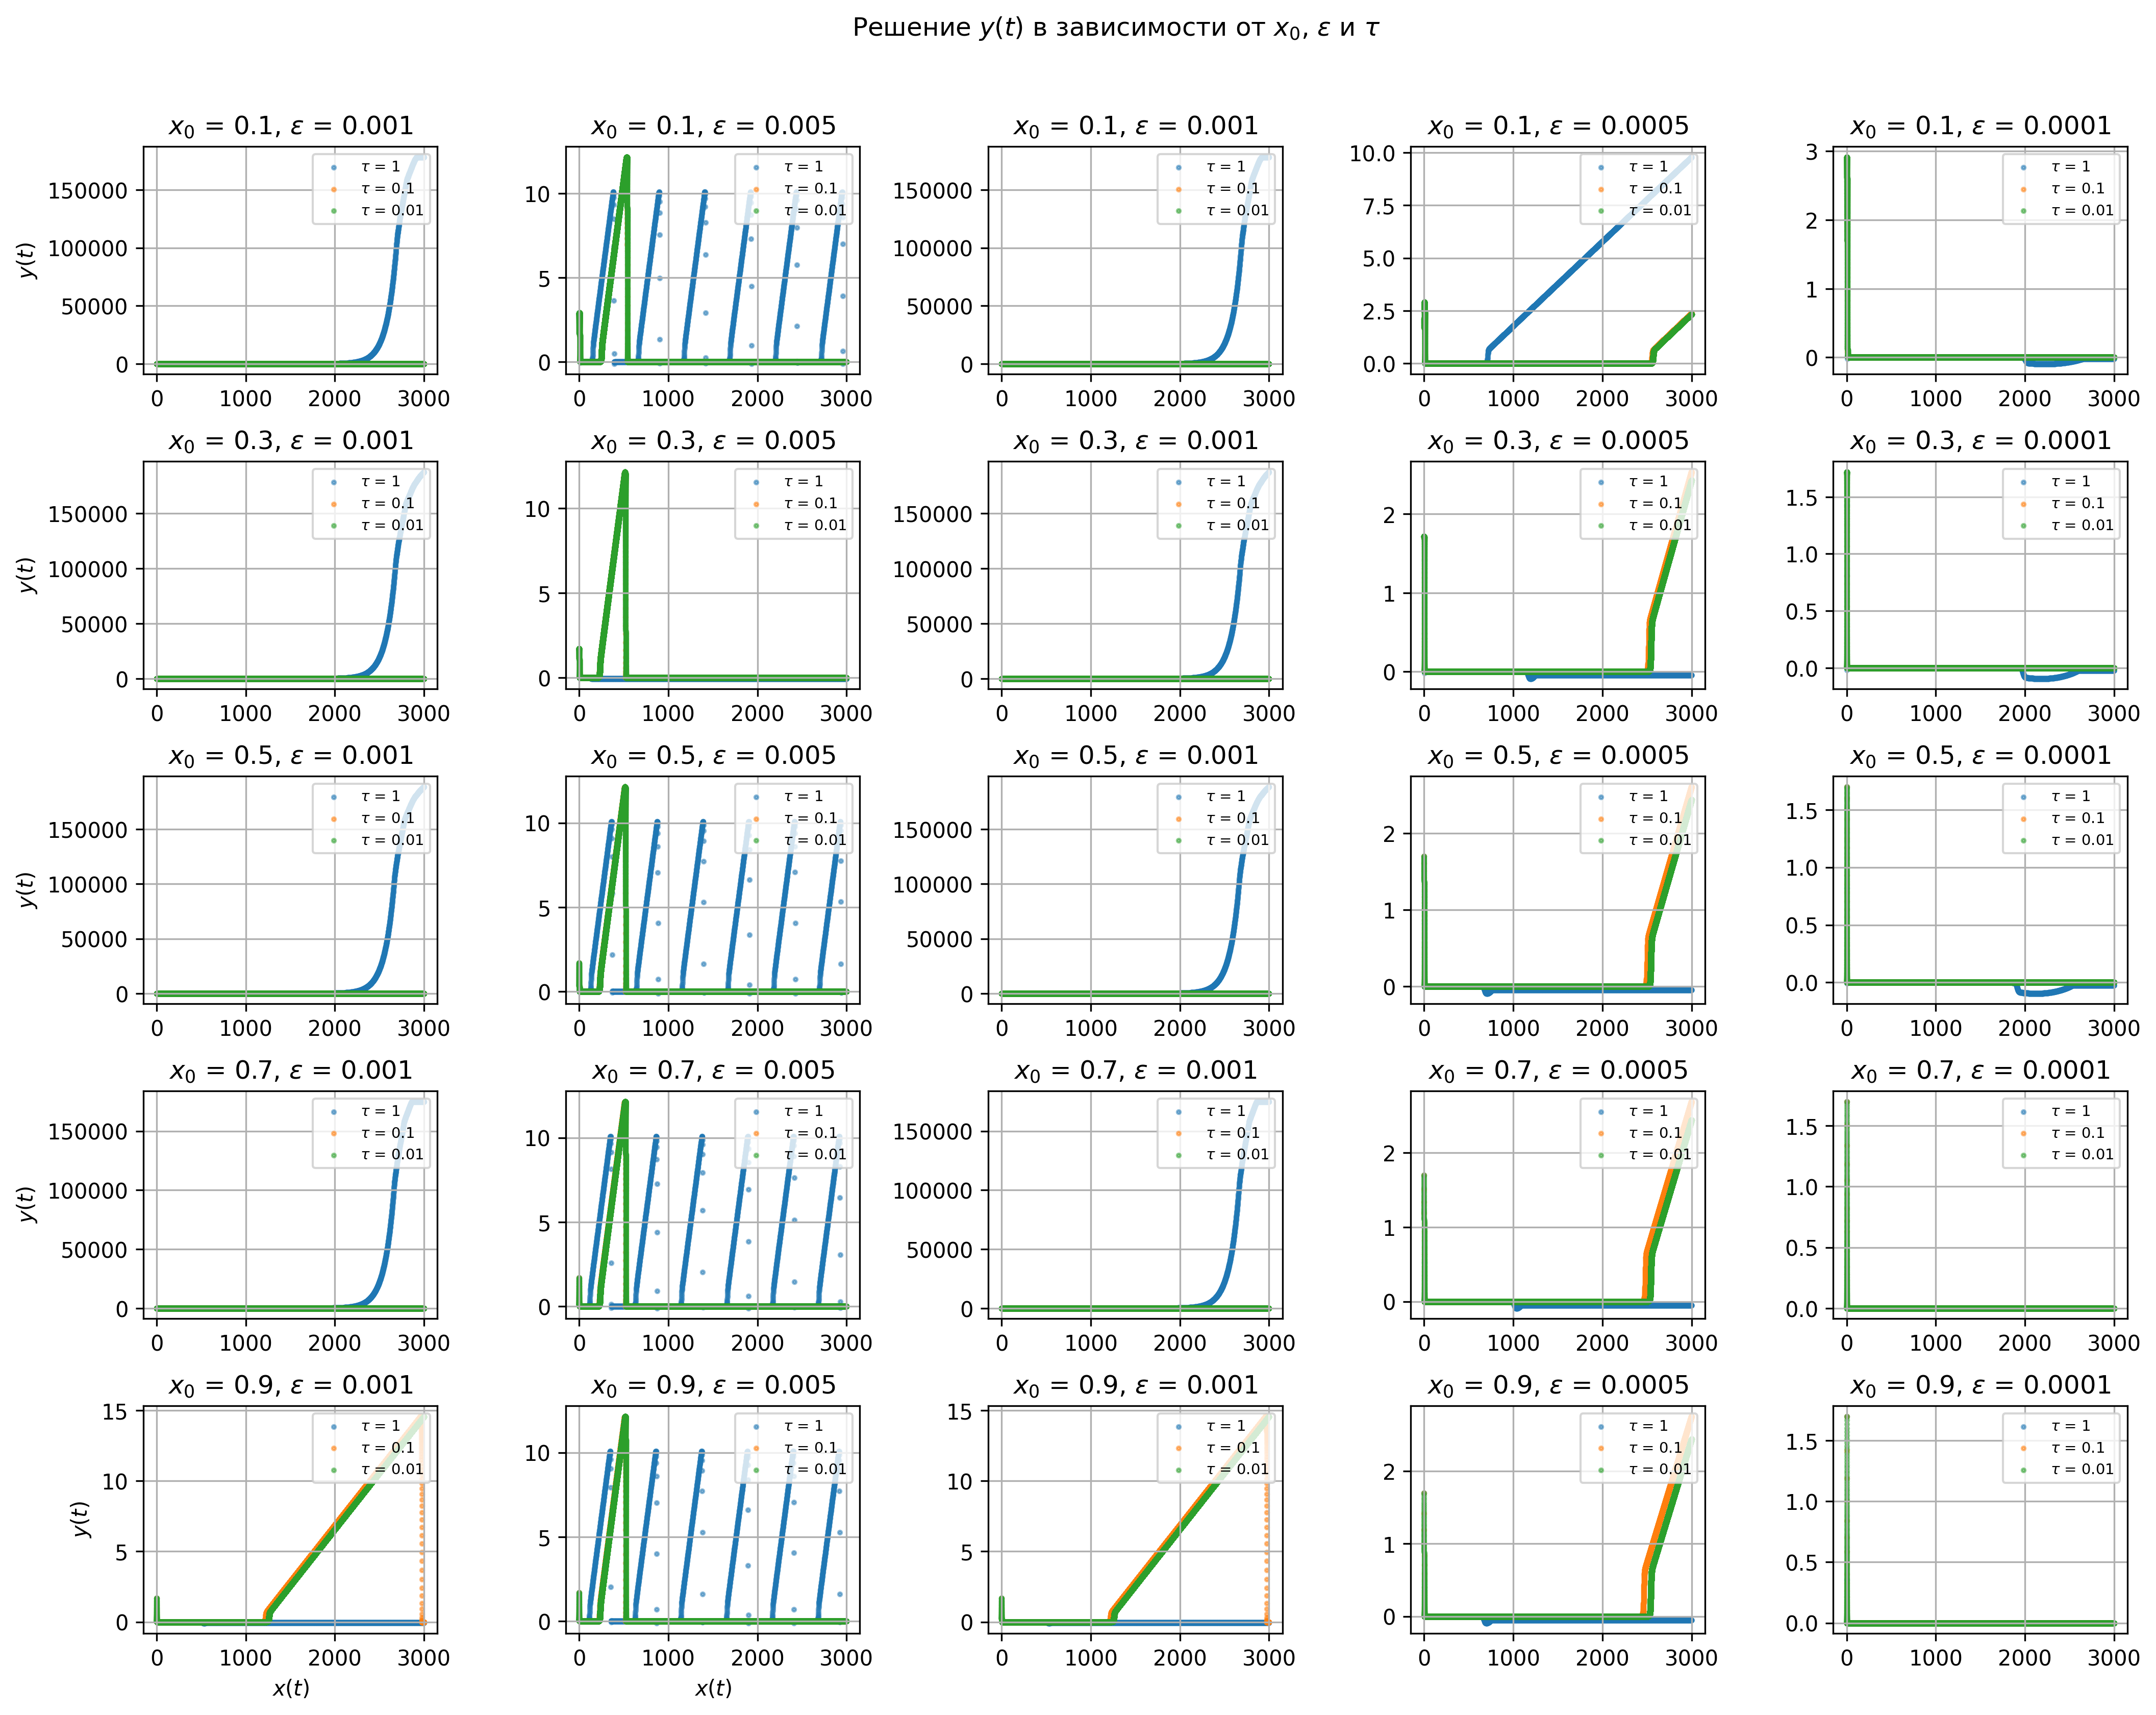

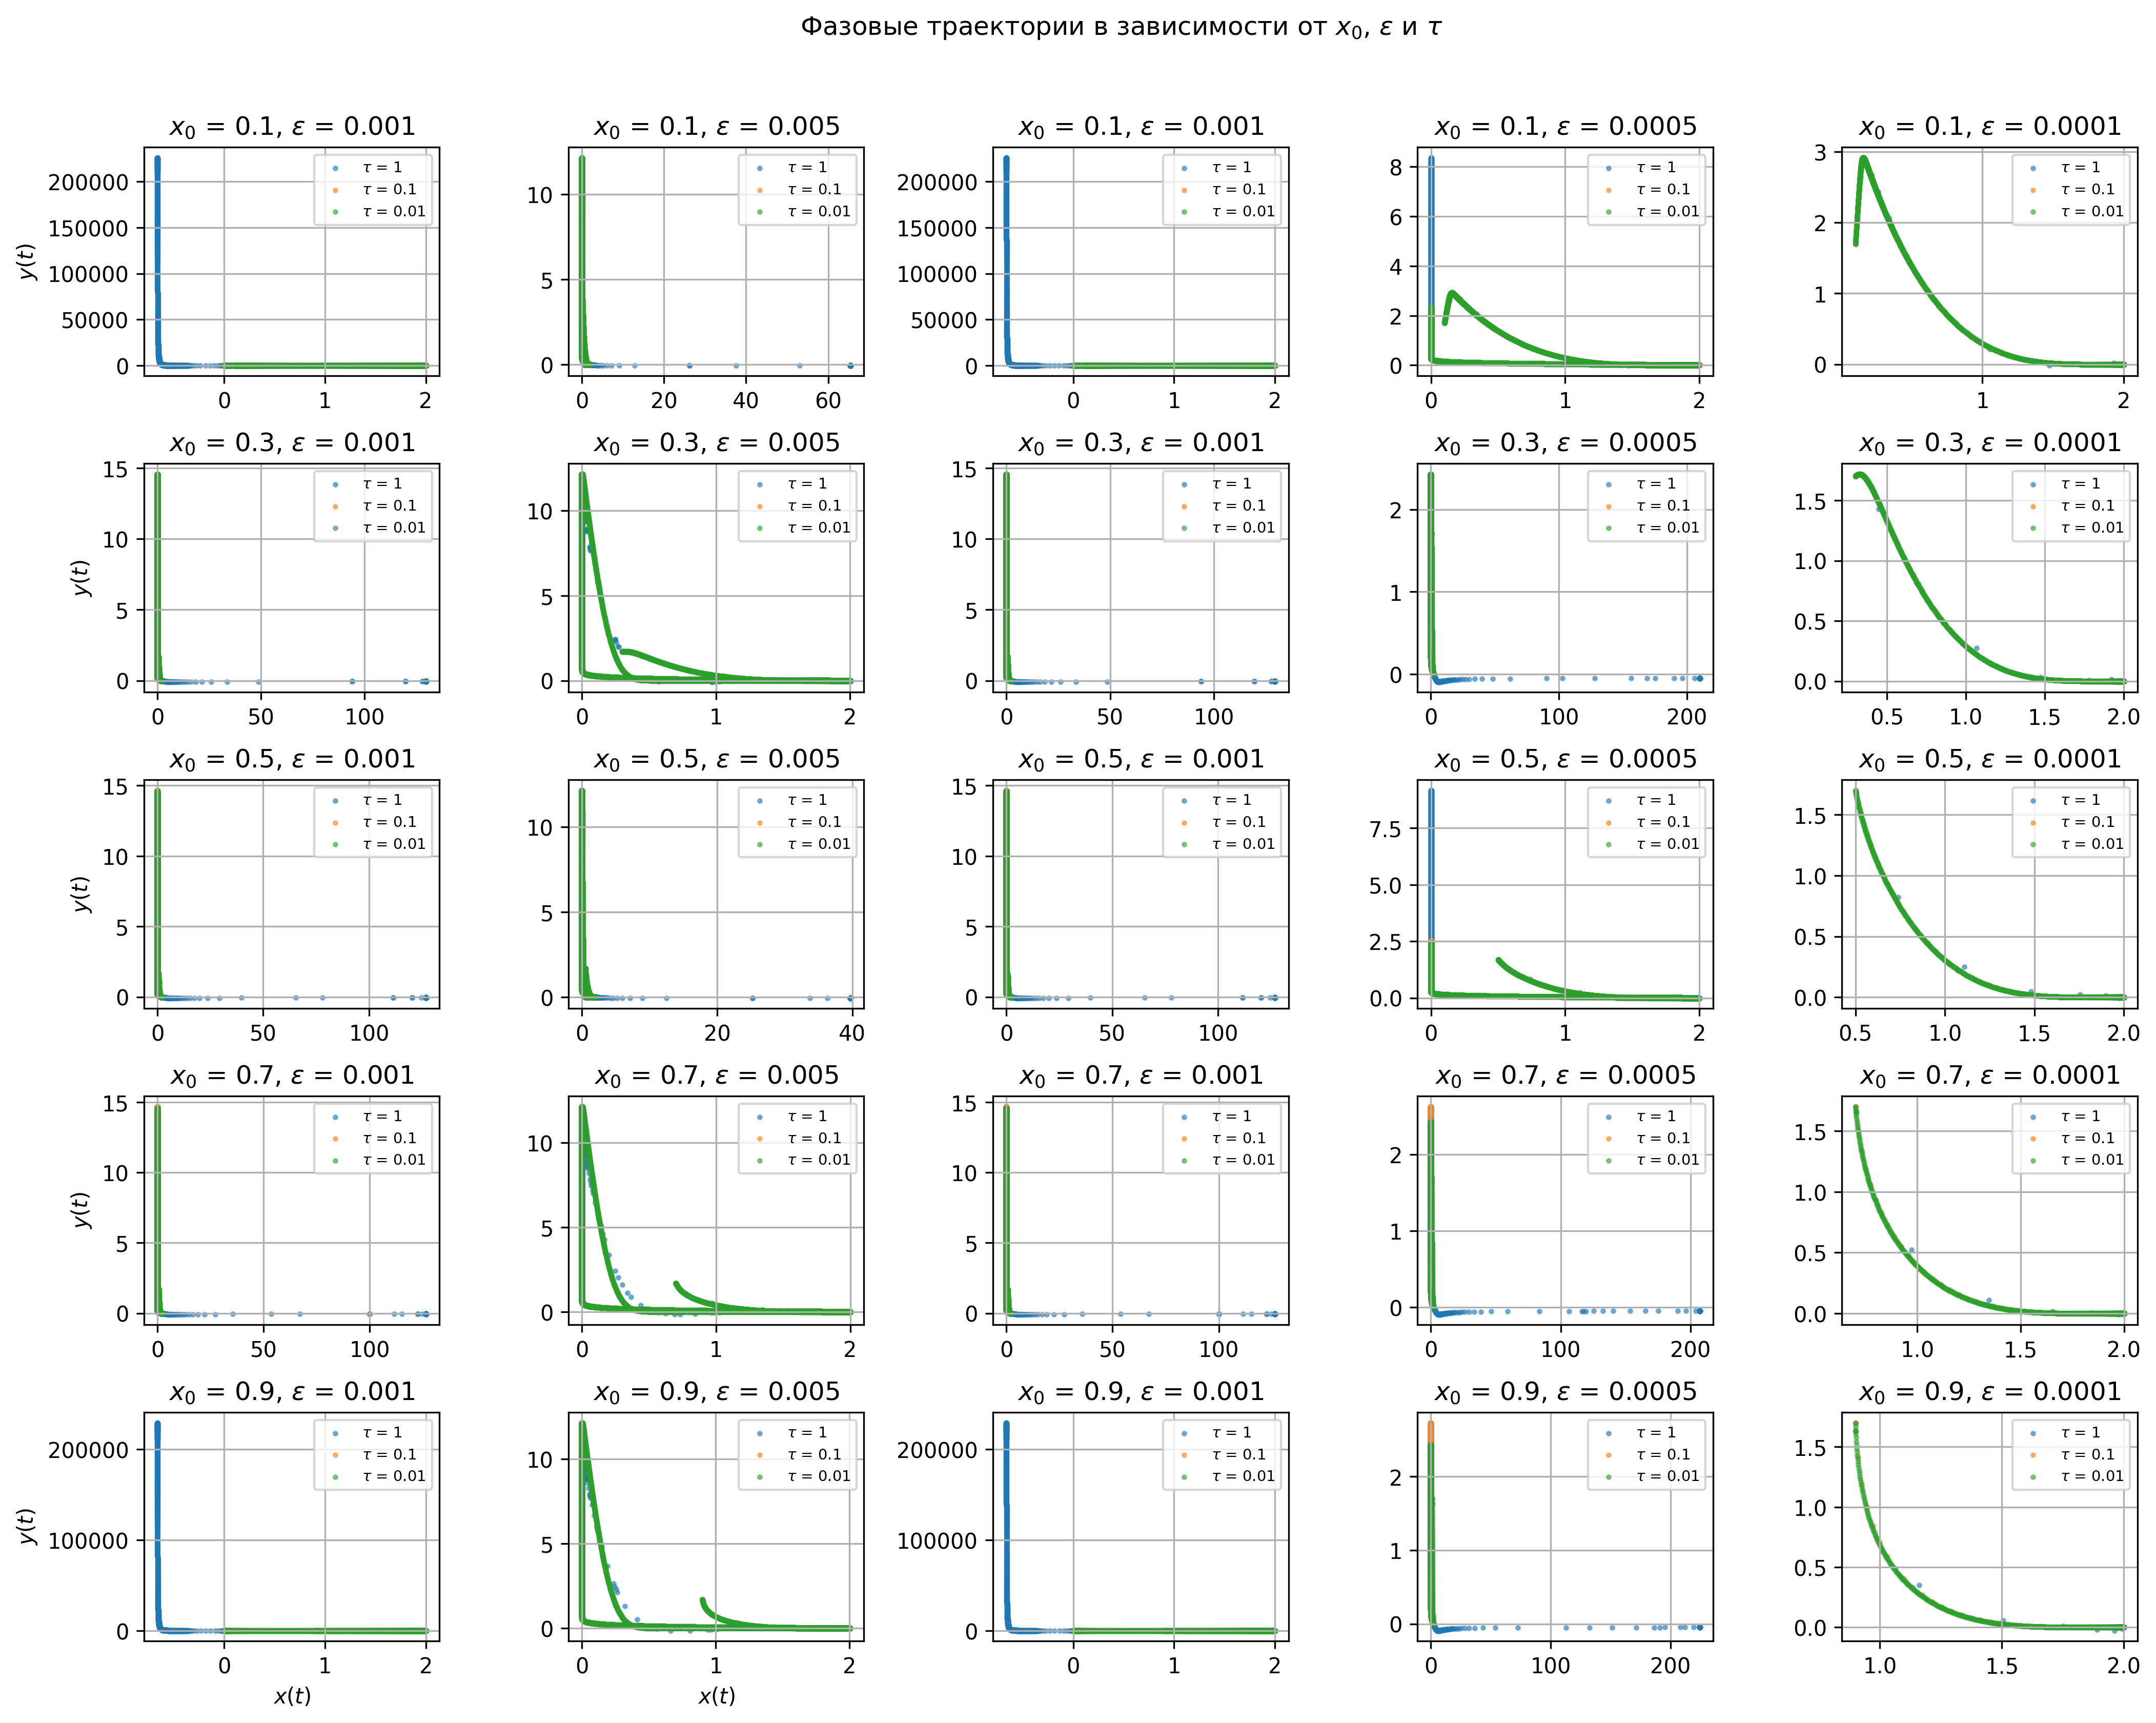

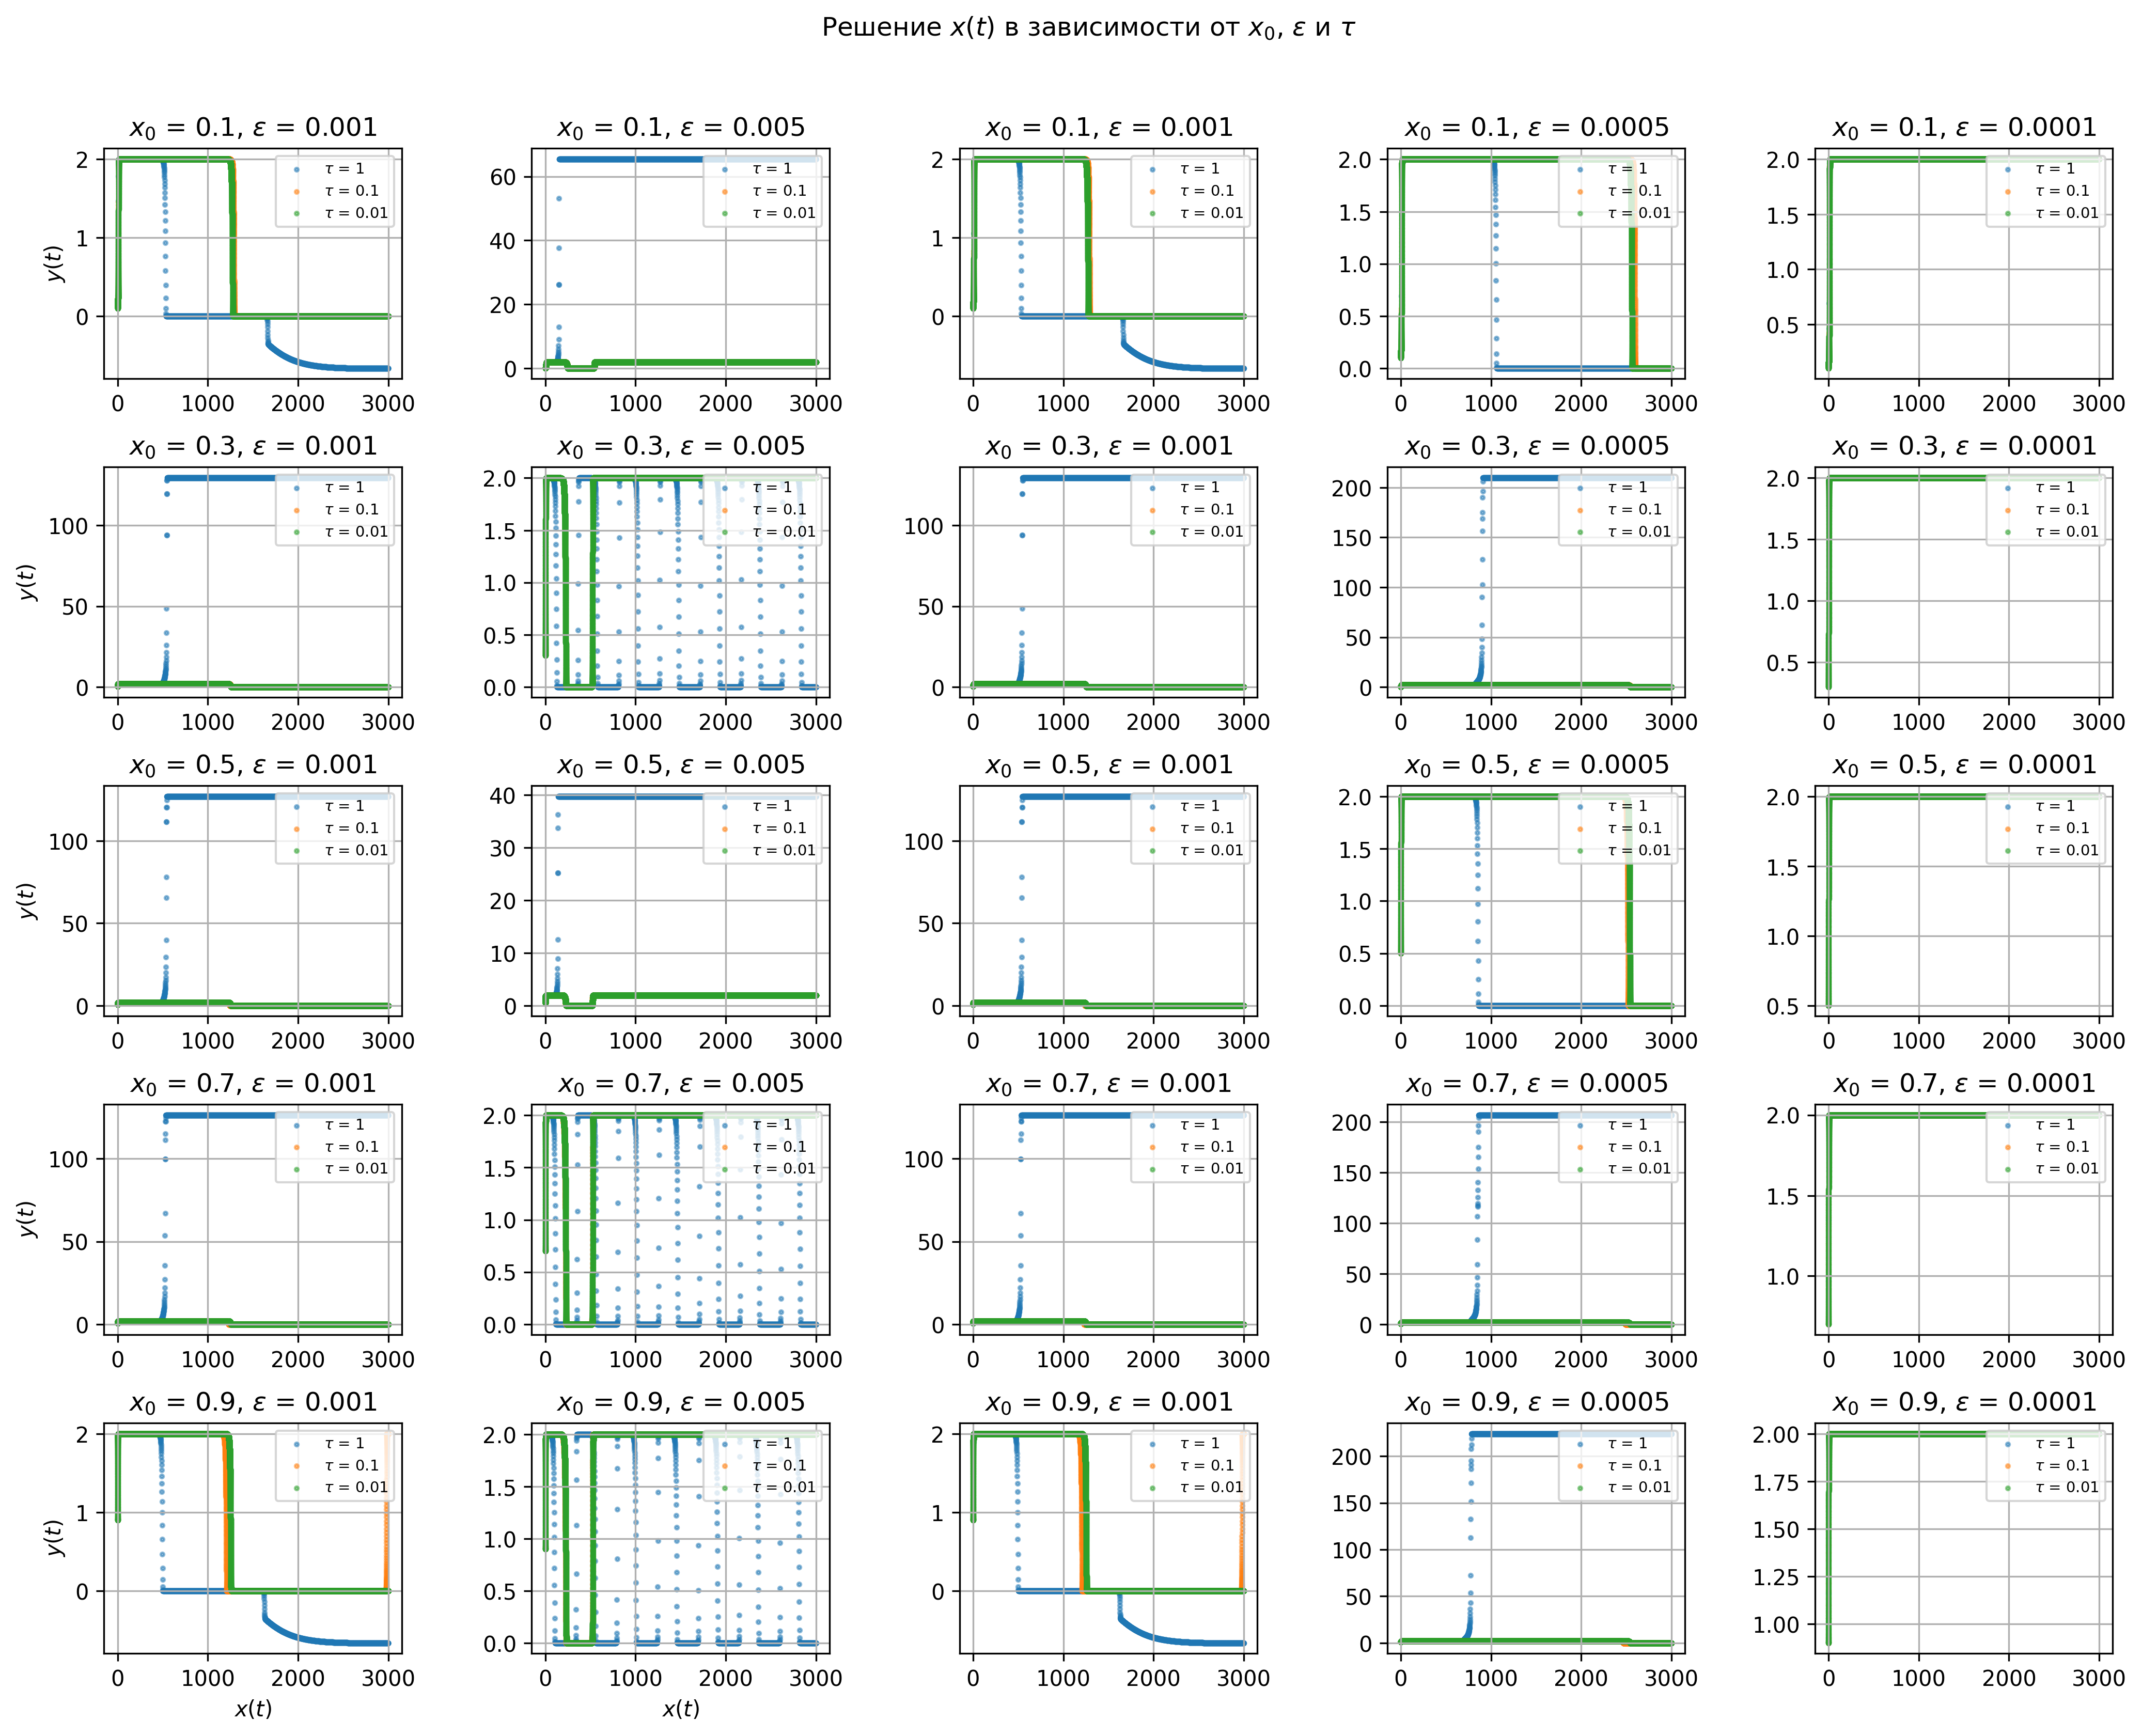

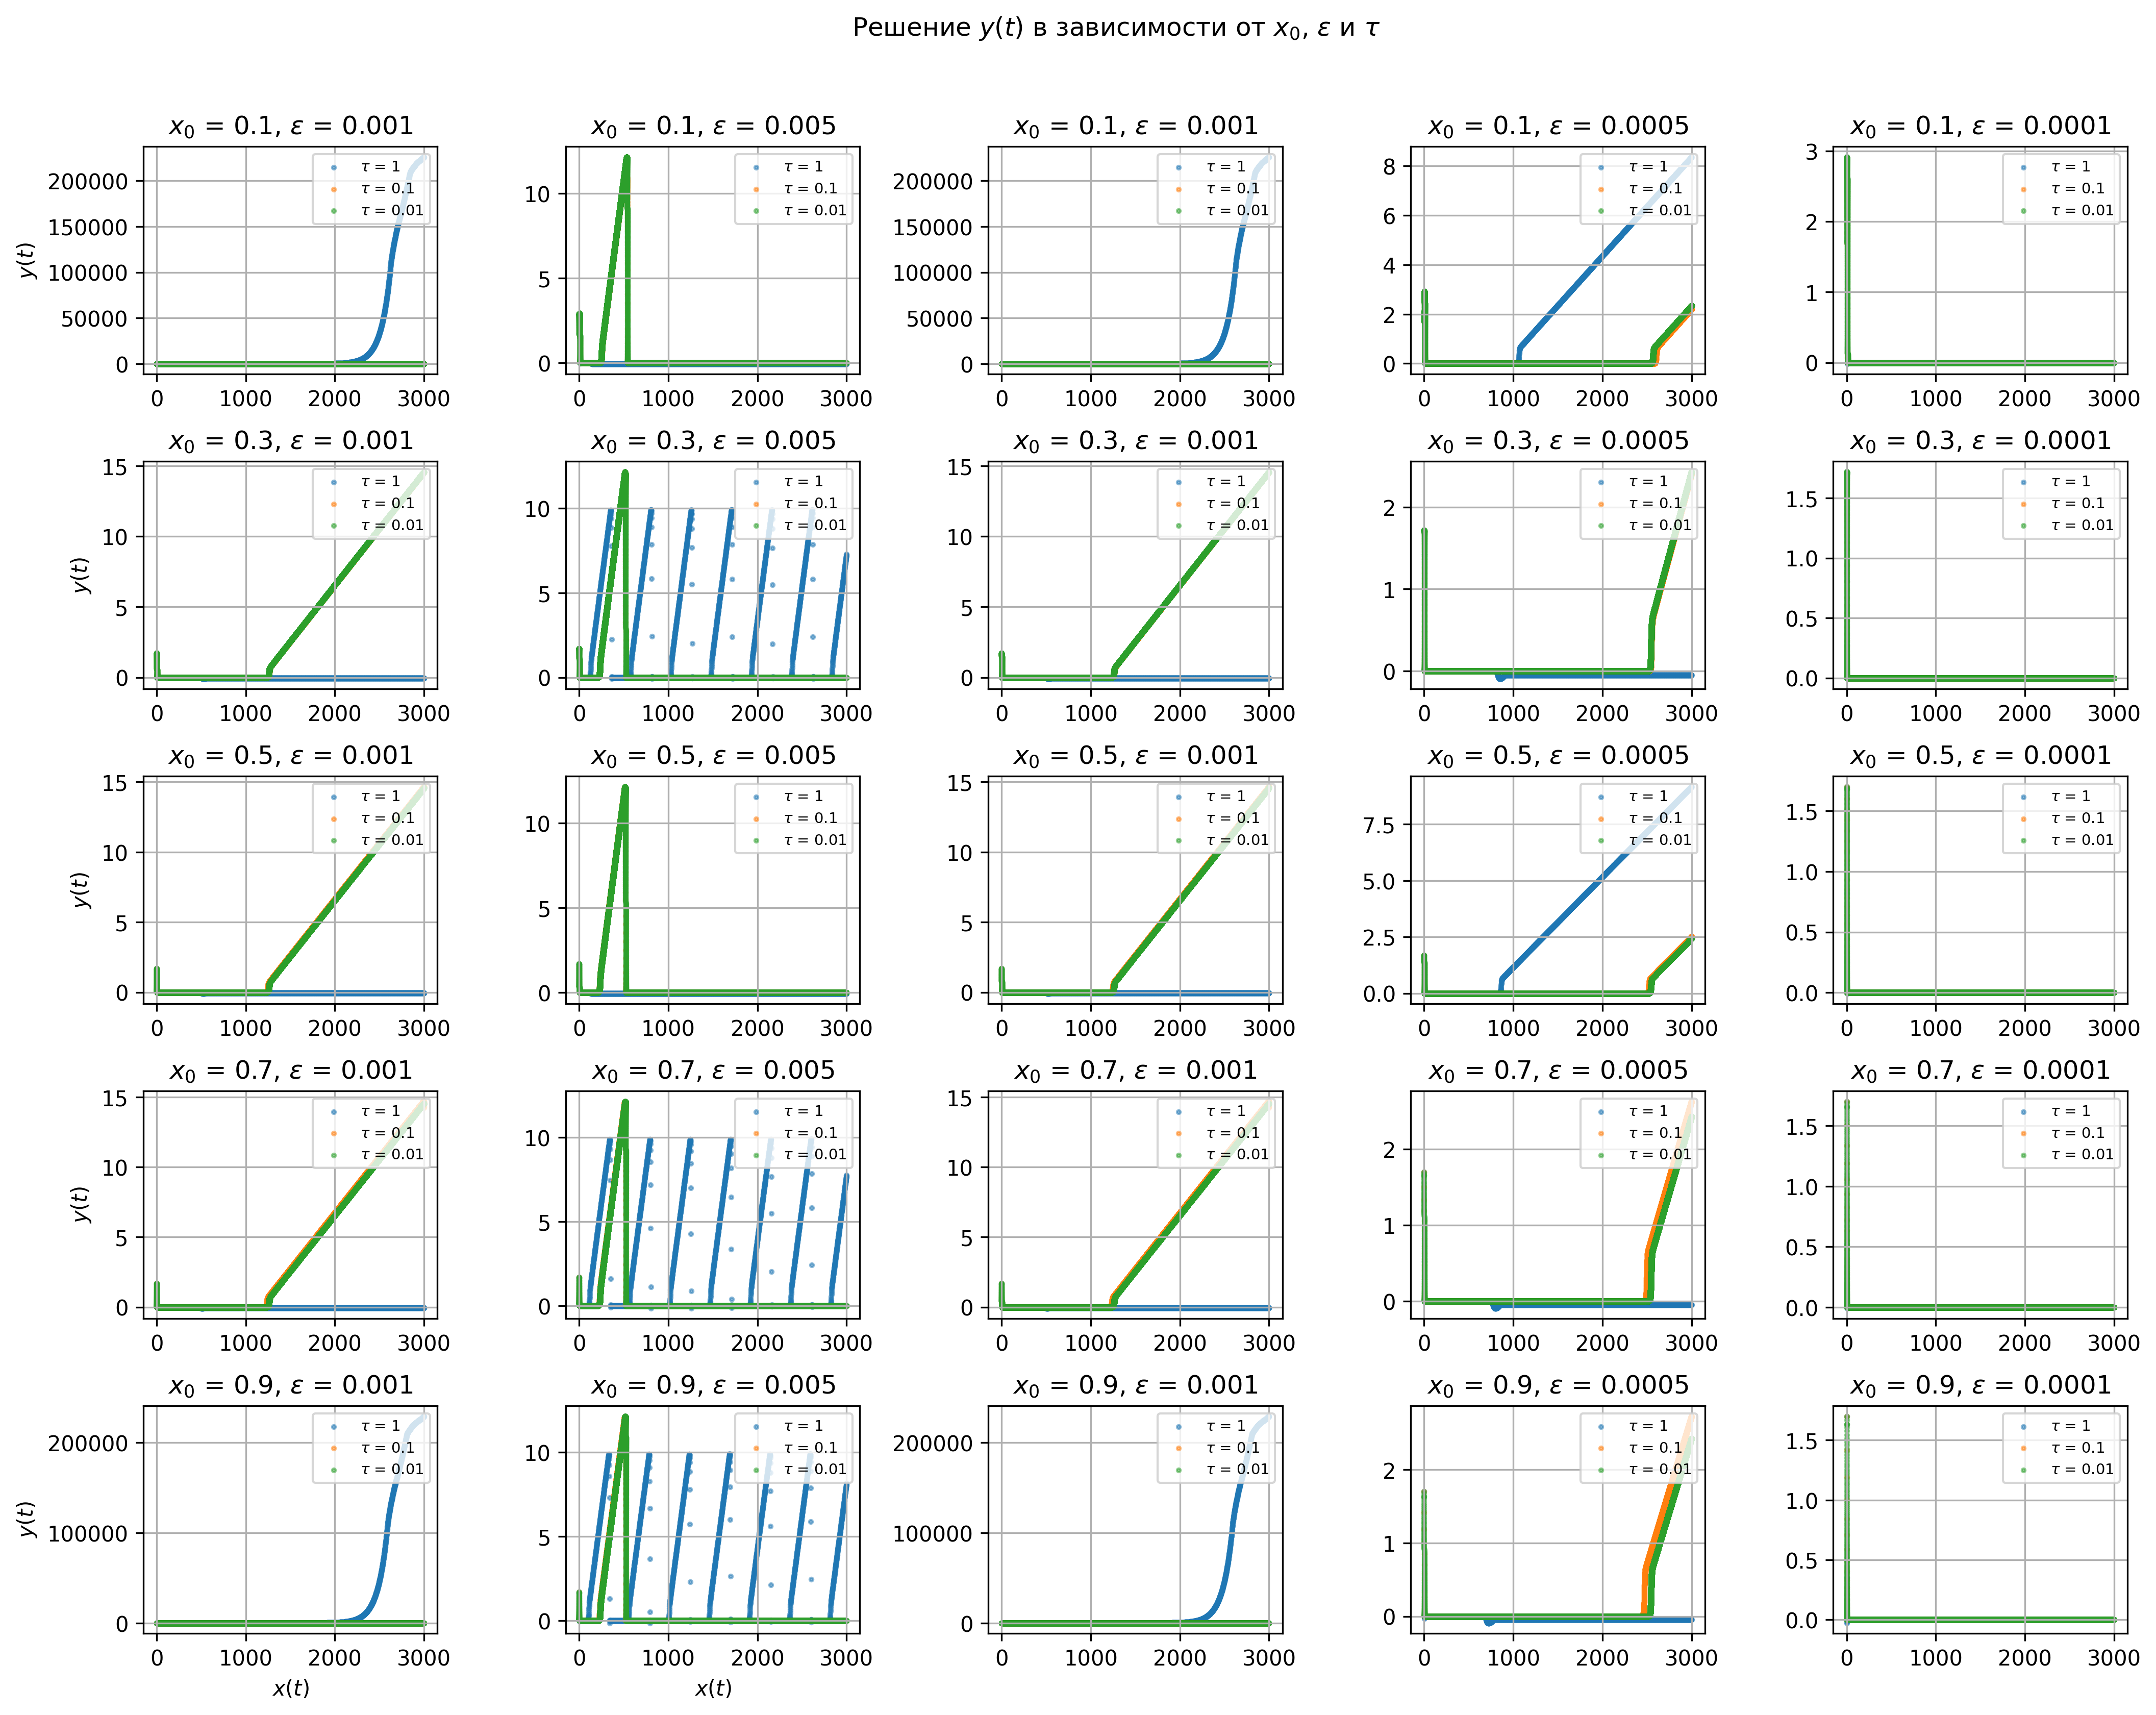

In [ ]:
for method in [BDF_order2, BDF_order3, BDF_order4]:
    plot_phase_diagrams_and_solutions(
        x0_arr=np.arange(0.1, 1.0, 0.2), 
        epsilon_arr=[1e-3, 5e-3, 1e-3, 5e-4, 1e-4], 
        tau_arr=[1, 0.1, 0.01],
        method=method
    )